# Assessing GDPR-Compliance in Web Applications: A Machine Learning Approach

We will assess the GDPR-compliance of web applications based on their privacy policies. We use a classification model, trained on a corpus of 18,397 natural sentences, to classify the privacy policies on whether five General Data Protection Regulation (GDPR) privacy policy core requirements are communicated in the policy.

__Relevance:__ The GDPR applies to any personal data processing of EU citizens. We aim to assess the state of GDPR-compliance in application software based on their privacy policies.

__Focus:__ web applications; as the web application paradigm is widely used due to the omnipresence of web browsers across PCs and mobile devices. 

__Goal:__ to scrutinize the privacy policies of web applications using ML, to assess whether core privacy policy requirements are communicated.

#### __RQ:__ What is the state of GDPR-compliance disclosure in web applications?

---

### Step 1: collect list of companies active in the Web Apps industry

To do so we utilize the Crunchbase database that allows us to identify companies that engage in web applications, filtered on location (which in our case will be the European Union). We used 

We've imported 2792 companies using the following criteria:
- Industry: Web Apps
- Location: Europe (European Union)

---

In [111]:
import os
from newspaper import Article
from bs4 import BeautifulSoup
from six.moves.urllib.parse import urlparse
import urllib
import sys
import time
import nltk
import pandas as pd
import requests
import spacy
import random
# from googlesearch import search
from langdetect import detect
import re
import pickle
import math
import numpy as np
import collections
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from tabulate import tabulate
from IPython.display import display, HTML

### Step 2: read data

In [14]:
# crunch_data_init = pd.read_excel('data/Advanced Search _ Companies _ Crunchbase.xlsx', index_col=0) 
crunch_data = pd.read_excel('data/companies.xlsx', index_col=0) 

In [88]:
crunch_data

,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,Contact Email,...,Industry 31,Industry 32,Industry 33,Industry 34,Industry 35,Industry 36,Industry 37,Link 1,Link 2,link_3
Identifier,,,,,,,,,,,,,,,,,,,,,
01s-community-company,01S Community company communicates and interac...,"Arezzo, Toscana, Italy",51-100,Private,www.01s.it/,"1,284,758",NaN,Active,For Profit,info@01s.it,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/01esse/,https://www.linkedin.com/company/01s-community...,NaN
1000-digital,1000 ° Digital develops innovative web applica...,"Leipzig, Sachsen, Germany",11-50,Private,www.1000grad.de,"1,480,851",2000,Active,For Profit,info@1000grad.de,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/1000graddigital,https://www.linkedin.com/company/1000digital/,https://twitter.com/1000digital
100-net,100% Net is a global internet solution for all...,"Pérols, Limousin, France",1-10,Private,www.100pour100net.com//,"986,874",2003,Active,For Profit,contact@100p100.net,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/100pour100Net/,https://www.linkedin.com/company/100-net/,https://www.twitter.com/100pour100net
100starlings,"100 Starlings creates web and mobile apps, the...","London, England, United Kingdom",1-10,Private,www.100starlings.com/,"388,746",2015,Active,For Profit,info@100starlings.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.linkedin.com/company/100starlings-...,https://twitter.com/100Starlings?utm_source=hi...,NaN
10geeks-software-engineering,"10Geeks designs, develops, and analyzes tailor...","Fohren, Baden-Wurttemberg, Germany",1-10,Private,www.10geeks.com,"651,610","Jan 1, 2012",Active,For Profit,info@10geeks.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.linkedin.com/company/10geeks,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zonova,Zonova is an information technology and servic...,"Terrenoire, Rhone-Alpes, France",11-50,Private,zonova.io,"853,916",2017,Active,For Profit,contact@zonova.io,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/ZetaOmegaNOVA/,https://www.linkedin.com/company/zonova/,NaN
zoonect,"Zoonect offers web apps, mobile app, cloud pla...","Pistoia, Toscana, Italy",1-10,Private,www.zoonect.com,"1,741,834",2015,Active,For Profit,office@zoonect.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/zoonect/,https://www.linkedin.com/company/zoonect/,https://twitter.com/zoonect
zostera,Zostera specializes provides software and data...,"Aarlanderveen, Zuid-Holland, The Netherlands",1-10,Private,zostera.nl,"1,839,410",NaN,Active,For Profit,info@zostera.nl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/zostera.bv,https://www.linkedin.com/company/zostera/,https://twitter.com/zostera


#### Clean websites list

In [17]:
websites_list = crunch_data["Website"].tolist()

In [18]:
websites_list

['www.01s.it/',
 'www.1000grad.de',
 'www.100pour100net.com//',
 'www.100starlings.com/',
 'www.10geeks.com',
 'www.121digitalmedia.eu/',
 '150sec.com/',
 'wollow-soft.com',
 '1minus1.com/',
 'www.1t-s.com',
 '21stwebb.co.uk',
 '23g.io',
 '247wms.com',
 '2advance.ch',
 'www.2develop.nl',
 'www.2m-a2i.fr/',
 'www.2open.it',
 'www.2see.nl',
 'www.2w.de',
 '33communication.com',
 'www.360d.be',
 'www.360telemetry.com/',
 'www.3asyr.com/',
 'www.3d3.nl/',
 'www.3d-dental.dk',
 '3dit.de; https//govie.de',
 '3ie.fr',
 'www.3m5.de',
 'www.3po.nl/',
 'www.3tiersystems.com',
 'www.3xw.ch',
 'www.40bis.nl',
 'www.4fx.co.uk/',
 'www.4homepages.de',
 '4kstudio.at',
 '4tpm.fr',
 '5w155.ch',
 '69pixl.com/',
 'www.7interactive.cz',
 'www.80si.com',
 'www.8balls.nl/',
 'www.8trust.com/',
 '8web.gr/',
 'www.960labs.com/',
 'www.999web.de',
 'www.99codelines.com',
 'a10sistemas.es',
 'a2colores.es',
 'www.aaltra.eu/',
 'aardenexperts.com/',
 'aardvark-creative.com',
 'www.aardvark.gr',
 'www.ab4d.com/',

In [19]:
# remove / from the end of the string that contains the website
# websites_list = [website.rstrip(website[-1]) if (website[-1] == "/") else website for website in websites_list]
websites_list = [website.rstrip(website[-1]) if (isinstance(website, str) and website[-1] == "/") else website for website in websites_list]
# een keer extra voor het geval er een url was met // op het eind
websites_list = [website.rstrip(website[-1]) if (isinstance(website, str) and website[-1] == "/") else website for website in websites_list]

In [70]:
len(websites_list)

2792

---

### Step 3: scrape privacy policies

In [21]:
def get_privacy_policy_url(query):
    keyword_in_title = 0
    attempts = 0
    url = ""
    print("Query: " + query)
    
    try:
        query_results_list = return_google_results(query, 3, 5)
        print("Considering " + str(len(query_results_list)) + " URL(s) ...")
        for i, url in enumerate(query_results_list):
            term_in_url = 0
            attempts = attempts + 1
            print("Assessing privacy policy URL: " + url)
            
            if (re.findall('privacy', url) or re.findall('policy', url)): 
                print("Found relevant terms in URL! Succesful break!")
                break

#                     pass
            if keyword_in_title == 1 or attempts == 3 or i==(len(query_results_list)-1): 
                keyword_in_title = 0
                attempts = 0
                print("No results. Breaking ..")
                url = ""
#                 print(sentences)
                break   
    except Exception as e:
            print(str(e))
            pass
    return url

In [22]:
def return_google_results(keywords, num_results, attempts):
    user_agent_list = [
      'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
      'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
      'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
      'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
      'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    ]

    html_keywords = urllib.parse.quote_plus(keywords)
    sleep_init = 10
    
    url = "https://www.google.com/search?q=" + html_keywords + "&num=" + str(num_results)
    print("** Search query in URL: " + url)

    headers = {'User-Agent': random.choice(user_agent_list)}
    
    html = requests.get(url, headers=headers)

    if html.status_code == 429:
        if(attempts == 0):
            sys.exit("Too many request 429, attempted "+ str(5)+ " times, break ...")
        else:
            if 'Retry_After' in html.headers:
                print("Helaas, geen retry-after info")
            else:
                time.sleep(sleep_init)
                print("Too many requests (attempt "+ str(5 - attempts)+ "), we will attempt again in " + str(sleep_init) + " seconds")
                return_google_results(keywords, num_results, (attempts - 1))
    else: 
        pass
        
    soup = BeautifulSoup(html.text, 'html.parser')

    allData = soup.find_all("div",{"class":"g"})

    link_list = []
    print("len alldata: " + str(len(allData)))
    
    for i in range(0,len(allData)):
        link = allData[i].find('a').get('href')
        
        if(link is not None):
            if(link.find('https') != -1 and link.find('http') == 0 and link.find('aclk') == -1):
                print(link)
                link_list.append(link)
    print(link_list)
    return link_list

#### Collect privacy policy URLs

In [28]:
privacy_policies_url_list = []

In [30]:
# loop through each company URL and attempt to find the URL of the privacy policy
for i, url_company in enumerate(websites_list[75:]):    
    print(i)

#     print(len(privacy_policies_url_list))
    if(isinstance("url_company", str) is False or (url_company == url_company) is False):
        privacy_policies_url_list.append("")
    else:
        query = "site:\"" + url_company + " \"privacy policy"
        privacy_policies_url_list.append(get_privacy_policy_url(query))
    print()
    time.sleep(60)

0
Query: site:"www.addink.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.addink.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1
Query: site:"a-digital.one "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22a-digital.one+%22privacy+policy&num=3
len alldata: 2
https://a-digital.one/magazin/wichtige-security-header-fuer-eure-website-und-wie-ihr-sie-einbindet/
https://a-digital.one/magazin/die-4-besten-dsgvo-generatoren-per-knopfdruck-zur-sicheren-datenschutzerklaerung/
['https://a-digital.one/magazin/wichtige-security-header-fuer-eure-website-und-wie-ihr-sie-einbindet/', 'https://a-digital.one/magazin/die-4-besten-dsgvo-generatoren-per-knopfdruck-zur-sicheren-datenschutzerklaerung/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://a-digital.one/magazin/wichtige-security-header-fuer-eure-website-und-wie-ihr-sie-einbindet/
Assessing privacy policy URL: https://a-digital.one/mag

25
Query: site:"www.aircury.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.aircury.com+%22privacy+policy&num=3
len alldata: 2
https://www.aircury.com/privacy-policy
https://www.aircury.com/cookie-policy
['https://www.aircury.com/privacy-policy', 'https://www.aircury.com/cookie-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.aircury.com/privacy-policy
Found relevant terms in URL! Succesful break!

26
Query: site:"airtven.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22airtven.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

27
Query: site:"www.ais.pl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ais.pl+%22privacy+policy&num=3
len alldata: 2
https://www.ais.pl/en/privacy-policy/
https://www.ais.pl/en/cookies/
['https://www.ais.pl/en/privacy-policy/', 'https://www.ais.pl/en/cookies/']
Considering 2 URL(s) ...
Assessing 

len alldata: 0
[]
Considering 0 URL(s) ...

53
Query: site:"allsop.software "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22allsop.software+%22privacy+policy&num=3
len alldata: 2
https://allsop.software/privacy-policy/
https://allsop.software/privacy-personal-data-protection-policy/
['https://allsop.software/privacy-policy/', 'https://allsop.software/privacy-personal-data-protection-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://allsop.software/privacy-policy/
Found relevant terms in URL! Succesful break!

54
Query: site:"www.allthingscode.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.allthingscode.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.allthingscode.co.uk/privacy
['https://www.allthingscode.co.uk/privacy']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.allthingscode.co.uk/privacy
Found relevant terms in URL! Succesful break!

55
Query: site:"w

76
Query: site:"www.activemindsolutions.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.activemindsolutions.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

77
Query: site:"amsterdamstandard.com/en "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22amsterdamstandard.com%2Fen+%22privacy+policy&num=3
len alldata: 2
https://amsterdamstandard.com/en/privacy-policy
https://amsterdamstandard.com/en/application/it-project-manager
['https://amsterdamstandard.com/en/privacy-policy', 'https://amsterdamstandard.com/en/application/it-project-manager']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://amsterdamstandard.com/en/privacy-policy
Found relevant terms in URL! Succesful break!

78
Query: site:"www.anakeen.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.anakeen.com+%22privacy+policy&num=3
len alldata: 1
https://www.anakeen.com/en/legal-no

103
Query: site:"www.applify.co "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.applify.co+%22privacy+policy&num=3
len alldata: 2
https://www.applify.co/privacy-policy
https://www.applify.co/disclaimer
['https://www.applify.co/privacy-policy', 'https://www.applify.co/disclaimer']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.applify.co/privacy-policy
Found relevant terms in URL! Succesful break!

104
Query: site:"www.appmodule.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.appmodule.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

105
Query: site:"www.appointmentor.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.appointmentor.com+%22privacy+policy&num=3
len alldata: 3
https://www.appointmentor.com/webpages/r4pages/OnlineBooking/SignUp.aspx?ClientID=824
https://www.appointmentor.com/webpages/r4pages/onlinebooking/SignUp.as

len alldata: 2
https://apro-software.com/privacy-policy/
https://apro-software.com/ai-and-privacy-unexpected-benefits/
['https://apro-software.com/privacy-policy/', 'https://apro-software.com/ai-and-privacy-unexpected-benefits/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://apro-software.com/privacy-policy/
Found relevant terms in URL! Succesful break!

125
Query: site:"www.apsynth.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.apsynth.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

126
Query: site:"www.aptaliko.gr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.aptaliko.gr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

127
Query: site:"aptho.es "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22aptho.es+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

128
Query: site:"apus3.com "privacy policy


148
Query: site:"www.ascami.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ascami.ch+%22privacy+policy&num=3
len alldata: 3
https://www.ascami.ch/privacy-policy/
https://www.ascami.ch/members/joergen_ahrens/
https://www.ascami.ch/
['https://www.ascami.ch/privacy-policy/', 'https://www.ascami.ch/members/joergen_ahrens/', 'https://www.ascami.ch/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.ascami.ch/privacy-policy/
Found relevant terms in URL! Succesful break!

149
Query: site:"www.ascentiv.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ascentiv.ch+%22privacy+policy&num=3
len alldata: 2
https://www.ascentiv.ch/kontakt/
https://www.ascentiv.ch/wissen/
['https://www.ascentiv.ch/kontakt/', 'https://www.ascentiv.ch/wissen/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.ascentiv.ch/kontakt/
Assessing privacy policy URL: https://www.ascentiv.ch/wissen/
No results. B

176
Query: site:"www.autentek.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.autentek.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

177
Query: site:"autojerry.fi "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22autojerry.fi+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

178
Query: site:"www.auxilis.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.auxilis.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

179
Query: site:"www.auxilium.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.auxilium.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

180
Query: site:"avocet.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22avocet.io+%22privacy+policy&num=3
len alldata: 2
https://avocet.io/privacy-policy
https://avocet.io/pri

202
Query: site:"www.barium.se "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.barium.se+%22privacy+policy&num=3
len alldata: 2
https://www.barium.se/en/products/low-code-platform/terms/privacy-policy-updated
https://www.barium.se/en/terms
['https://www.barium.se/en/products/low-code-platform/terms/privacy-policy-updated', 'https://www.barium.se/en/terms']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.barium.se/en/products/low-code-platform/terms/privacy-policy-updated
Found relevant terms in URL! Succesful break!

203
Query: site:"www.baselab.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.baselab.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

204
Query: site:"www.baseplate.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.baseplate.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

205
Query: site:"www.s

225
Query: site:"www.bgssoft.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bgssoft.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

226
Query: site:"www.bh-webentwicklung.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bh-webentwicklung.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

227
Query: site:"biffbangpow.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22biffbangpow.com+%22privacy+policy&num=3
len alldata: 2
https://biffbangpow.com/privacy-policy/
https://biffbangpow.com/data-processor-agreement/
['https://biffbangpow.com/privacy-policy/', 'https://biffbangpow.com/data-processor-agreement/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://biffbangpow.com/privacy-policy/
Found relevant terms in URL! Succesful break!

228
Query: site:"www.bilpp.com "privacy policy
** Search query in URL: https://www.go

len alldata: 0
[]
Considering 0 URL(s) ...

247
Query: site:"blackfire.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22blackfire.io+%22privacy+policy&num=3
len alldata: 2
https://blackfire.io/privacy
https://blackfire.io/cookie-policy
['https://blackfire.io/privacy', 'https://blackfire.io/cookie-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://blackfire.io/privacy
Found relevant terms in URL! Succesful break!

248
Query: site:"blanko.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22blanko.de+%22privacy+policy&num=3
len alldata: 3
https://buero-blanko.de/kontakt
https://buero-blanko.de/portfolio/
https://buero-blanko.de/professionelle-webseite/
['https://buero-blanko.de/kontakt', 'https://buero-blanko.de/portfolio/', 'https://buero-blanko.de/professionelle-webseite/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://buero-blanko.de/kontakt
Assessing privacy policy URL: https://b

271
Query: site:"www.boringowl.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.boringowl.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

272
Query: site:"www.bososoft.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bososoft.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

273
Query: site:"boulder-design.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22boulder-design.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.boulder-design.co.uk/privacy.html
https://www.boulder-design.co.uk/terms-of-use.html
['https://www.boulder-design.co.uk/privacy.html', 'https://www.boulder-design.co.uk/terms-of-use.html']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.boulder-design.co.uk/privacy.html
Found relevant terms in URL! Succesful break!

274
Query: site:"www.boxharry.com "privacy policy
** Search query in UR

297
Query: site:"www.bs-systeme.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bs-systeme.de+%22privacy+policy&num=3
len alldata: 2
https://www.bs-systeme.de/en/eco2lot/unser-service/schulung/verbindungsmanager
https://www.bs-systeme.de/datenschutz
['https://www.bs-systeme.de/en/eco2lot/unser-service/schulung/verbindungsmanager', 'https://www.bs-systeme.de/datenschutz']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.bs-systeme.de/en/eco2lot/unser-service/schulung/verbindungsmanager
Assessing privacy policy URL: https://www.bs-systeme.de/datenschutz
No results. Breaking ..

298
Query: site:"www.werbeagentur.ms "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.werbeagentur.ms+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

299
Query: site:"www.bsystem.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bsystem.ch+%22privacy+policy&num=

322
Query: site:"calculate.plus "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22calculate.plus+%22privacy+policy&num=3
len alldata: 3
https://calculate.plus/en/terms
https://calculate.plus/en/login
https://calculate.plus/en/contact
['https://calculate.plus/en/terms', 'https://calculate.plus/en/login', 'https://calculate.plus/en/contact']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://calculate.plus/en/terms
Assessing privacy policy URL: https://calculate.plus/en/login
Assessing privacy policy URL: https://calculate.plus/en/contact
No results. Breaking ..

323
Query: site:"calcupal.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22calcupal.be+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

324
Query: site:"www.calder.sk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.calder.sk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

32

len alldata: 2
[]
Considering 0 URL(s) ...

348
Query: site:"castor-web-design.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22castor-web-design.com+%22privacy+policy&num=3
len alldata: 3
[]
Considering 0 URL(s) ...

349
Query: site:"www.catchbull.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.catchbull.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

350
Query: site:"www.cazemo.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cazemo.com+%22privacy+policy&num=3
len alldata: 1
https://www.cazemo.com/client/registration
['https://www.cazemo.com/client/registration']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.cazemo.com/client/registration
No results. Breaking ..

351
Query: site:"www.cartodecision.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cartodecision.fr+%22privacy+policy&nu

370
Query: site:"www.sites-chirdent.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sites-chirdent.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

371
Query: site:"www.chittak.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.chittak.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.chittak.co.uk/seo.php
https://www.chittak.co.uk/design.php
['https://www.chittak.co.uk/seo.php', 'https://www.chittak.co.uk/design.php']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.chittak.co.uk/seo.php
Assessing privacy policy URL: https://www.chittak.co.uk/design.php
No results. Breaking ..

372
Query: site:"choicely.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22choicely.com+%22privacy+policy&num=3
len alldata: 3
https://support.choicely.com/privacy/
https://www.choicely.com/en/choicely-the-best-no-code-mobile-app-editor-2
['https

len alldata: 2
[]
Considering 0 URL(s) ...

399
Query: site:"www.cmcitymedia.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cmcitymedia.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

400
Query: site:"www.cmslabs.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cmslabs.it+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

401
Query: site:"www.bigbase.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.bigbase.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

402
Query: site:"cockpit-sante.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22cockpit-sante.fr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

403
Query: site:"www.codeagency.pl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.codeagency.pl+%22privacy+policy&num

len alldata: 2
https://www.cogitoweb.it/privacy-policy/
https://www.cogitoweb.it/cookie-policy/
['https://www.cogitoweb.it/privacy-policy/', 'https://www.cogitoweb.it/cookie-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.cogitoweb.it/privacy-policy/
Found relevant terms in URL! Succesful break!

427
Query: site:"www.cognifide.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cognifide.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

428
Query: site:"cogniteq.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22cogniteq.com+%22privacy+policy&num=3
len alldata: 2
https://www.cogniteq.com/privacy_policy
['https://www.cogniteq.com/privacy_policy']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.cogniteq.com/privacy_policy
Found relevant terms in URL! Succesful break!

429
Query: site:"cognitic.be "privacy policy
** Search query in URL: https://www

452
Query: site:"www.connectedsoftec.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.connectedsoftec.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

453
Query: site:"studioconnecte.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22studioconnecte.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

454
Query: site:"www.connectlime.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.connectlime.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

455
Query: site:"connexionsw.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22connexionsw.com+%22privacy+policy&num=3
len alldata: 2
https://connexionsw.com/about/policy/
https://connexionsw.com/blog/post/apprenticeship-opportunity/
['https://connexionsw.com/about/policy/', 'https://connexionsw.com/blog/post/apprenticeship-opportunity

476
Query: site:"www.corobori.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.corobori.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

477
Query: site:"www.cortex-media.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cortex-media.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

478
Query: site:"www.corussoft.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.corussoft.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

479
Query: site:"www.cotunity.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cotunity.com+%22privacy+policy&num=3
len alldata: 1
https://www.cotunity.com/policies/
['https://www.cotunity.com/policies/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.cotunity.com/policies/
No results. Breaking ..

480
Query: site:"www.coveronwe

501
Query: site:"www.crispy-it.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.crispy-it.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

502
Query: site:"www.critec.pt "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.critec.pt+%22privacy+policy&num=3
len alldata: 2
https://www.critec.pt/privacy-policy
https://www.critec.pt/home
['https://www.critec.pt/privacy-policy', 'https://www.critec.pt/home']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.critec.pt/privacy-policy
Found relevant terms in URL! Succesful break!

503
Query: site:"www.crm-infosys.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.crm-infosys.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

504
Query: site:"www.crobasoft.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.crobasoft.com+%22privacy+policy&n

len alldata: 2
https://www.damidev.com/en/terms-and-conditions
https://www.damidev.com/en/blog/top-5-aplikaci-s-nejlepsi-prihlasovaci-obrazovkou
['https://www.damidev.com/en/terms-and-conditions', 'https://www.damidev.com/en/blog/top-5-aplikaci-s-nejlepsi-prihlasovaci-obrazovkou']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.damidev.com/en/terms-and-conditions
Assessing privacy policy URL: https://www.damidev.com/en/blog/top-5-aplikaci-s-nejlepsi-prihlasovaci-obrazovkou
No results. Breaking ..

525
Query: site:"www.danburykline.co.uk/DK "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.danburykline.co.uk%2FDK+%22privacy+policy&num=3
len alldata: 2
https://www.danburykline.co.uk/DK/policies.html
https://www.danburykline.co.uk/DK/terms.html
['https://www.danburykline.co.uk/DK/policies.html', 'https://www.danburykline.co.uk/DK/terms.html']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.danburykline.co.uk/DK/poli

549
Query: site:"www.mydcs.gr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mydcs.gr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

550
Query: site:"www.dcsoftware.pt "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.dcsoftware.pt+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

551
Query: site:"www.debondt.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.debondt.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

552
Query: site:"www.debugged.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.debugged.be+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

553
Query: site:"debugme.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22debugme.eu+%22privacy+policy&num=3
len alldata: 1
https://www.debugme.eu/privacybeleid/
['https://

579
Query: site:"www.devault.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.devault.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

580
Query: site:"it.devbu.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22it.devbu.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

581
Query: site:"www.devconsultberlin.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.devconsultberlin.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

582
Query: site:"www.devdivision.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.devdivision.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

583
Query: site:"devedis.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22devedis.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...


len alldata: 0
[]
Considering 0 URL(s) ...

607
Query: site:"digitaldragonsglobal.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22digitaldragonsglobal.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

608
Query: site:"www.digitalestate.tech "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.digitalestate.tech+%22privacy+policy&num=3
len alldata: 2
https://www.digitalestate.tech/privacy-policy
https://www.digitalestate.tech/partners
['https://www.digitalestate.tech/privacy-policy', 'https://www.digitalestate.tech/partners']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.digitalestate.tech/privacy-policy
Found relevant terms in URL! Succesful break!

609
Query: site:"www.thedigitalists.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.thedigitalists.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

610
Query: site

len alldata: 0
[]
Considering 0 URL(s) ...

632
Query: site:"docaret.com/en "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22docaret.com%2Fen+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

633
Query: site:"www.docospot.dk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.docospot.dk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

634
Query: site:"www.doc-safe.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.doc-safe.co.uk+%22privacy+policy&num=3
len alldata: 3
https://www.doc-safe.co.uk/servlet/com.scl.horus?service=desktop_x1&function=news_direct&id=1189&nacc=0
https://www.doc-safe.co.uk/servlet/com.scl.horus?service=news_x1&function=view&id=1189
['https://www.doc-safe.co.uk/servlet/com.scl.horus?service=desktop_x1&function=news_direct&id=1189&nacc=0', 'https://www.doc-safe.co.uk/servlet/com.scl.horus?service=news_x1&function=view&id=

len alldata: 3
https://www.dreamsolution.nl/what-we-do.html
https://www.dreamsolution.nl/20180914-algemene-voorwaarden-dreamsolution.pdf
https://www.dreamsolution.nl/responsible-disclosure.html
['https://www.dreamsolution.nl/what-we-do.html', 'https://www.dreamsolution.nl/20180914-algemene-voorwaarden-dreamsolution.pdf', 'https://www.dreamsolution.nl/responsible-disclosure.html']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.dreamsolution.nl/what-we-do.html
Assessing privacy policy URL: https://www.dreamsolution.nl/20180914-algemene-voorwaarden-dreamsolution.pdf
Assessing privacy policy URL: https://www.dreamsolution.nl/responsible-disclosure.html
No results. Breaking ..

655
Query: site:"dreipol.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22dreipol.ch+%22privacy+policy&num=3
len alldata: 2
https://www.dreipol.ch/datenschutz
['https://www.dreipol.ch/datenschutz']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://w

679
Query: site:"www.easyfeedback.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.easyfeedback.com+%22privacy+policy&num=3
len alldata: 3
https://www.easyfeedback.com/laexperiencia/statics/en/marca.html
https://www.easyfeedback.com/laexperiencia/statics/en/contacto.html
https://www.easyfeedback.com/laexperiencia/statics/en/medios.html
['https://www.easyfeedback.com/laexperiencia/statics/en/marca.html', 'https://www.easyfeedback.com/laexperiencia/statics/en/contacto.html', 'https://www.easyfeedback.com/laexperiencia/statics/en/medios.html']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.easyfeedback.com/laexperiencia/statics/en/marca.html
Assessing privacy policy URL: https://www.easyfeedback.com/laexperiencia/statics/en/contacto.html
Assessing privacy policy URL: https://www.easyfeedback.com/laexperiencia/statics/en/medios.html
No results. Breaking ..

680
Query: site:"www.easyleaving.com "privacy policy
** Search query in U

704
Query: site:"www.efigence.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.efigence.com+%22privacy+policy&num=3
len alldata: 2
https://www.efigence.com/privacy-policy/
https://www.efigence.com/contact/
['https://www.efigence.com/privacy-policy/', 'https://www.efigence.com/contact/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.efigence.com/privacy-policy/
Found relevant terms in URL! Succesful break!

705
Query: site:"egebit.com.tr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22egebit.com.tr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

706
Query: site:"www.egotec.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.egotec.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

707
Query: site:"www.eisod.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.eisod.com+%22privac

733
Query: site:"www.enhance.ie "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.enhance.ie+%22privacy+policy&num=3
len alldata: 2
https://www.enhance.ie/privacy-policy/
https://www.enhance.ie/cookie-policy/
['https://www.enhance.ie/privacy-policy/', 'https://www.enhance.ie/cookie-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.enhance.ie/privacy-policy/
Found relevant terms in URL! Succesful break!

734
Query: site:"www.enigmasoft.ltd.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.enigmasoft.ltd.uk+%22privacy+policy&num=3
len alldata: 2
https://www.enigmasoft.ltd.uk/privacy-policy.html
https://www.enigmasoft.ltd.uk/terms-and-conditions.html
['https://www.enigmasoft.ltd.uk/privacy-policy.html', 'https://www.enigmasoft.ltd.uk/terms-and-conditions.html']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.enigmasoft.ltd.uk/privacy-policy.html
Found relevant terms in 

len alldata: 0
[]
Considering 0 URL(s) ...

758
Query: site:"www.etelenima.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.etelenima.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

759
Query: site:"www.etgigrup.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.etgigrup.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

760
Query: site:"etiqa.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22etiqa.it+%22privacy+policy&num=3
len alldata: 2
https://etiqa.it/contact-us
https://etiqa.it/services
['https://etiqa.it/contact-us', 'https://etiqa.it/services']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://etiqa.it/contact-us
Assessing privacy policy URL: https://etiqa.it/services
No results. Breaking ..

761
Query: site:"www.etiskapp.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22w

len alldata: 0
[]
Considering 0 URL(s) ...

785
Query: site:"exaitec.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22exaitec.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

786
Query: site:"www.excel-help.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.excel-help.eu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

787
Query: site:"www.exigeapp.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.exigeapp.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

788
Query: site:"exit25.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22exit25.it+%22privacy+policy&num=3
len alldata: 3
https://www.exit25.it/politica-sulla-privacy.html
https://www.exit25.it/cookie.html
['https://www.exit25.it/politica-sulla-privacy.html', 'https://www.exit25.it/cookie.html']
Considering 2 URL(s) ...
Ass

len alldata: 0
[]
Considering 0 URL(s) ...

812
Query: site:"fingersfingers.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22fingersfingers.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

813
Query: site:"fiberjungle.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22fiberjungle.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

814
Query: site:"fiduro.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22fiduro.net+%22privacy+policy&num=3
len alldata: 1
https://www.fiduro.net/sl/documents/adobe-creative_cloud_teams_edu_overview.pdf
['https://www.fiduro.net/sl/documents/adobe-creative_cloud_teams_edu_overview.pdf']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.fiduro.net/sl/documents/adobe-creative_cloud_teams_edu_overview.pdf
No results. Breaking ..

815
Query: site:"fill.ly "privacy policy
** Search query in URL:

len alldata: 0
[]
Considering 0 URL(s) ...

836
Query: site:"foiz.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22foiz.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

837
Query: site:"foliovision.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22foliovision.com+%22privacy+policy&num=3
len alldata: 3
https://foliovision.com/registration/privacy-policy
https://foliovision.com/2022/01/how-privacy-is-made
https://foliovision.com/2011/01/apple-privacy-policies-like-microsoft
['https://foliovision.com/registration/privacy-policy', 'https://foliovision.com/2022/01/how-privacy-is-made', 'https://foliovision.com/2011/01/apple-privacy-policies-like-microsoft']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://foliovision.com/registration/privacy-policy
Found relevant terms in URL! Succesful break!

838
Query: site:"www.foodnotify.com "privacy policy
** Search query in URL: https://www.goo

len alldata: 0
[]
Considering 0 URL(s) ...

853
Query: site:"www.fps.hu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.fps.hu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

854
Query: site:"www.fraktal.co "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.fraktal.co+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

855
Query: site:"www.freeformcreative.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.freeformcreative.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

856
Query: site:"freetimefor.biz "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22freetimefor.biz+%22privacy+policy&num=3
len alldata: 2
https://freetimefor.biz/
https://freetimefor.biz/condizioni/privacy/
['https://freetimefor.biz/', 'https://freetimefor.biz/condizioni/privacy/']
Considering 2 URL(s) ...
Assessing

879
Query: site:"galadrim.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22galadrim.fr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

880
Query: site:"gallimedia.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gallimedia.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

881
Query: site:"token.gamee.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22token.gamee.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

882
Query: site:"www.gammadia.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.gammadia.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

883
Query: site:"gangverk.is "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gangverk.is+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

884
Query: site:"info.g

len alldata: 0
[]
Considering 0 URL(s) ...

903
Query: site:"gestionmedica.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gestionmedica.com+%22privacy+policy&num=3
len alldata: 1
https://gestionmedica.com/politica-privacidad-redes-sociales/
['https://gestionmedica.com/politica-privacidad-redes-sociales/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://gestionmedica.com/politica-privacidad-redes-sociales/
No results. Breaking ..

904
Query: site:"gewoon-peter.nl/webstudio.php "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gewoon-peter.nl%2Fwebstudio.php+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

905
Query: site:"www.gfactory.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.gfactory.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

906
Query: site:"www.ggate.it "privacy policy
** Search query in URL: https://www.go

len alldata: 0
[]
Considering 0 URL(s) ...

928
Query: site:"www.goal043.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.goal043.nl+%22privacy+policy&num=3
len alldata: 3
https://www.goal043.nl/privacy-statement-allaboardnow/
https://www.goal043.nl/privacy/
https://www.goal043.nl/dementiegame-algemene-voorwaarden/
['https://www.goal043.nl/privacy-statement-allaboardnow/', 'https://www.goal043.nl/privacy/', 'https://www.goal043.nl/dementiegame-algemene-voorwaarden/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.goal043.nl/privacy-statement-allaboardnow/
Found relevant terms in URL! Succesful break!

929
Query: site:"gobrilla.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gobrilla.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

930
Query: site:"gold-dev.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22gold-dev.com+%22privacy+po

len alldata: 0
[]
Considering 0 URL(s) ...

956
Query: site:"www.hairfie.com/fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.hairfie.com%2Ffr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

957
Query: site:"hal.si "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22hal.si+%22privacy+policy&num=3
len alldata: 2
https://vps-red.hal.si/privacy-policy/
https://vps-red.hal.si/cookie-policy/
['https://vps-red.hal.si/privacy-policy/', 'https://vps-red.hal.si/cookie-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://vps-red.hal.si/privacy-policy/
Found relevant terms in URL! Succesful break!

958
Query: site:"hallingdata.no "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22hallingdata.no+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

959
Query: site:"www.handshakeit.ch "privacy policy
** Search query in URL: https://www.google.com

979
Query: site:"herimpact.co "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22herimpact.co+%22privacy+policy&num=3
HTTPSConnectionPool(host='www.google.com', port=443): Max retries exceeded with url: /search?q=site%3A%22herimpact.co+%22privacy+policy&num=3 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001D7D98BFEE0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

980
Query: site:"herocoders.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22herocoders.com+%22privacy+policy&num=3
HTTPSConnectionPool(host='www.google.com', port=443): Max retries exceeded with url: /search?q=site%3A%22herocoders.com+%22privacy+policy&num=3 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001D7D98BFA60>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

981
Query: site:"www.herodot.com "privacy policy
** Search query i

999
Query: site:"www.jungoag.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.jungoag.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1000
Query: site:"hpscds.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22hpscds.com+%22privacy+policy&num=3
len alldata: 2
https://hpscds.com/en/contact/
https://hpscds.com/observatorio-hp/observatorio-hp-21-22/
['https://hpscds.com/en/contact/', 'https://hpscds.com/observatorio-hp/observatorio-hp-21-22/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://hpscds.com/en/contact/
Assessing privacy policy URL: https://hpscds.com/observatorio-hp/observatorio-hp-21-22/
No results. Breaking ..

1001
Query: site:"www.hqss.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.hqss.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1002
Query: site:"media-systeme.de "privacy policy
** Search query

len alldata: 0
[]
Considering 0 URL(s) ...

1025
Query: site:"www.ictnet.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ictnet.uk+%22privacy+policy&num=3
len alldata: 2
https://www.ictnet.uk/about/
https://www.ictnet.uk/contact/
['https://www.ictnet.uk/about/', 'https://www.ictnet.uk/contact/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.ictnet.uk/about/
Assessing privacy policy URL: https://www.ictnet.uk/contact/
No results. Breaking ..

1026
Query: site:"idamas.lt "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22idamas.lt+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1027
Query: site:"iddqd.org "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22iddqd.org+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1028
Query: site:"www.ideabits.se "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22

1055
Query: site:"www.imagospirit.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.imagospirit.fr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1056
Query: site:"www.imaker.no "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.imaker.no+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1057
Query: site:"www.imcservice.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.imcservice.eu+%22privacy+policy&num=3
len alldata: 2
https://www.imcservice.eu/en/services/
https://www.imcservice.eu/en/about-us/
['https://www.imcservice.eu/en/services/', 'https://www.imcservice.eu/en/about-us/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.imcservice.eu/en/services/
Assessing privacy policy URL: https://www.imcservice.eu/en/about-us/
No results. Breaking ..

1058
Query: site:"impactory.org "privacy policy
** Search query in URL: 

1084
Query: site:"infoberry.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22infoberry.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1085
Query: site:"info-consulting.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22info-consulting.fr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1086
Query: site:"www.infoconsulting.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.infoconsulting.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1087
Query: site:"www.infoframe.hu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.infoframe.hu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1088
Query: site:"www.infomanager.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.infomanager.it+%22privacy+policy&num=3
len alldata: 2
htt

len alldata: 0
[]
Considering 0 URL(s) ...

1111
Query: site:"www.inouit.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.inouit.fr+%22privacy+policy&num=3
len alldata: 1
https://www.inouit.fr/mentions-legales
['https://www.inouit.fr/mentions-legales']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.inouit.fr/mentions-legales
No results. Breaking ..

1112
Query: site:"www.inovamatic.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.inovamatic.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1113
Query: site:"www.inpaginasas.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.inpaginasas.it+%22privacy+policy&num=3
len alldata: 1
https://www.inpaginasas.it/assets/privacy.pdf
['https://www.inpaginasas.it/assets/privacy.pdf']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.inpaginasas.it/assets/privacy.pdf
Found re

len alldata: 3
https://www.inventis.be/nl-be/artikels/is-de-privacy-policy-op-jouw-website-klaar-voor-gdpr
https://www.inventis.be/nl-be/privacy-policy
https://www.inventis.be/nl-be/artikels?category=GDPR
['https://www.inventis.be/nl-be/artikels/is-de-privacy-policy-op-jouw-website-klaar-voor-gdpr', 'https://www.inventis.be/nl-be/privacy-policy', 'https://www.inventis.be/nl-be/artikels?category=GDPR']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.inventis.be/nl-be/artikels/is-de-privacy-policy-op-jouw-website-klaar-voor-gdpr
Found relevant terms in URL! Succesful break!

1140
Query: site:"inventive.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22inventive.co.uk+%22privacy+policy&num=3
len alldata: 3
[]
Considering 0 URL(s) ...

1141
Query: site:"invid.no "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22invid.no+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1142
Query: sit

1160
Query: site:"islagrafica.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22islagrafica.com+%22privacy+policy&num=3
len alldata: 3
https://islagrafica.com/en/privacy-policy/
https://islagrafica.com/en/cookies-policy/
https://islagrafica.com/en/who-we-are/
['https://islagrafica.com/en/privacy-policy/', 'https://islagrafica.com/en/cookies-policy/', 'https://islagrafica.com/en/who-we-are/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://islagrafica.com/en/privacy-policy/
Found relevant terms in URL! Succesful break!

1161
Query: site:"www.isotoma.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.isotoma.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1162
Query: site:"www.ist.com/dk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ist.com%2Fdk+%22privacy+policy&num=3
len alldata: 1
https://www.ist.com/dk/cookiepolitik/
['https://www.i

1188
Query: site:"www.itsorce.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.itsorce.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1189
Query: site:"it-tecture.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22it-tecture.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1190
Query: site:"www.itti.com.pl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.itti.com.pl+%22privacy+policy&num=3
len alldata: 2
https://www.itti.com.pl/en/privacy-policy/
https://www.itti.com.pl/dowiedz-sie-wiecej/why-you-to-hire-a-lawyer-to-prepare-your-privacy-policy/
['https://www.itti.com.pl/en/privacy-policy/', 'https://www.itti.com.pl/dowiedz-sie-wiecej/why-you-to-hire-a-lawyer-to-prepare-your-privacy-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.itti.com.pl/en/privacy-policy/
Found relevant terms in URL! Succesful bre

1215
Query: site:"www.joeallenpro.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.joeallenpro.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1216
Query: site:"journalisticapp.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22journalisticapp.com+%22privacy+policy&num=3
len alldata: 2
https://journalisticapp.com/privacy
https://journalisticapp.com/blog/talking-privacy-of-journaling-apps
['https://journalisticapp.com/privacy', 'https://journalisticapp.com/blog/talking-privacy-of-journaling-apps']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://journalisticapp.com/privacy
Found relevant terms in URL! Succesful break!

1217
Query: site:"jscrambler.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22jscrambler.com+%22privacy+policy&num=3
len alldata: 2
https://docs.jscrambler.com/privacy-and-security
https://docs.jscrambler.com/privacy-and-se

len alldata: 0
[]
Considering 0 URL(s) ...

1239
Query: site:"kanbanone.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22kanbanone.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1240
Query: site:"kanev.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22kanev.com+%22privacy+policy&num=3
len alldata: 2
https://kanev.com/privacy-policy
https://kanev.com/support/taxi-booking/1502-add-private-data-protection-text-on-button-terms-and-conditions
['https://kanev.com/privacy-policy', 'https://kanev.com/support/taxi-booking/1502-add-private-data-protection-text-on-button-terms-and-conditions']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://kanev.com/privacy-policy
Found relevant terms in URL! Succesful break!

1241
Query: site:"kant.ist/global "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22kant.ist%2Fglobal+%22privacy+policy&num=3
len alldata: 0
[]
C

1265
Query: site:"kiwihr.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22kiwihr.com+%22privacy+policy&num=3
len alldata: 2
https://kiwihr.com/privacy-policy
https://kiwihr.com/gdpr-policy
['https://kiwihr.com/privacy-policy', 'https://kiwihr.com/gdpr-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://kiwihr.com/privacy-policy
Found relevant terms in URL! Succesful break!

1266
Query: site:"www.klar-automation.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.klar-automation.de+%22privacy+policy&num=3
len alldata: 2
[]
Considering 0 URL(s) ...

1267
Query: site:"klassroom.co "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22klassroom.co+%22privacy+policy&num=3
len alldata: 3
https://klassroom.co/terms-of-use
https://klassroom.co/privacy
https://web.klassroom.co/
['https://klassroom.co/terms-of-use', 'https://klassroom.co/privacy', 'https://web.klassroom.co/']

len alldata: 3
https://zattoo-website-preprod.kreios.lu/privacy-policy/
https://zattoo-website-preprod.kreios.lu/team-members/bastian-eller/
https://zattoo-website-preprod.kreios.lu/offers/bridge/?lang=de
['https://zattoo-website-preprod.kreios.lu/privacy-policy/', 'https://zattoo-website-preprod.kreios.lu/team-members/bastian-eller/', 'https://zattoo-website-preprod.kreios.lu/offers/bridge/?lang=de']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://zattoo-website-preprod.kreios.lu/privacy-policy/
Found relevant terms in URL! Succesful break!

1293
Query: site:"kroosp.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22kroosp.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1294
Query: site:"www.kryax.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.kryax.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1295
Query: site:"www.k-system.cz "privacy policy


1316
Query: site:"www.lawmedia.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.lawmedia.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1317
Query: site:"www.lead9.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.lead9.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1318
Query: site:"weareleaf.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22weareleaf.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1319
Query: site:"leanbakery.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22leanbakery.com+%22privacy+policy&num=3
len alldata: 1
[]
Considering 0 URL(s) ...

1320
Query: site:"www.leanpanda.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.leanpanda.com+%22privacy+policy&num=3
len alldata: 2
https://www.leanpanda.com/headless-

len alldata: 0
[]
Considering 0 URL(s) ...

1344
Query: site:"www.linaware.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.linaware.eu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1345
Query: site:"www.linea11.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.linea11.com+%22privacy+policy&num=3
len alldata: 1
https://www.linea11.com/agency-about/informativa-sulla-privacy/
['https://www.linea11.com/agency-about/informativa-sulla-privacy/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.linea11.com/agency-about/informativa-sulla-privacy/
Found relevant terms in URL! Succesful break!

1346
Query: site:"lingohub.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22lingohub.com+%22privacy+policy&num=3
len alldata: 2
https://lingohub.com/privacy
https://lingohub.com/security
['https://lingohub.com/privacy', 'https://lingohub.com/security

len alldata: 0
[]
Considering 0 URL(s) ...

1371
Query: site:"loopohost.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22loopohost.com+%22privacy+policy&num=3
len alldata: 3
https://loopohost.com/privacy-policy/
https://loopohost.com/terms-and-conditions/
https://loopohost.com/
['https://loopohost.com/privacy-policy/', 'https://loopohost.com/terms-and-conditions/', 'https://loopohost.com/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://loopohost.com/privacy-policy/
Found relevant terms in URL! Succesful break!

1372
Query: site:"www.loopy.fi "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.loopy.fi+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1373
Query: site:"www.loqipa.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.loqipa.com+%22privacy+policy&num=3
len alldata: 1
https://www.loqipa.com/en/gdpr/
['https://www.loqipa.com/en/gdpr/'

1396
Query: site:"www.magerman.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.magerman.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1397
Query: site:"www.magichouse.cz "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.magichouse.cz+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1398
Query: site:"www.magicsquaresystems.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.magicsquaresystems.com+%22privacy+policy&num=3
len alldata: 2
https://www.magicsquaresystems.com/legal/terms
https://www.magicsquaresystems.com/legal/cookies
['https://www.magicsquaresystems.com/legal/terms', 'https://www.magicsquaresystems.com/legal/cookies']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.magicsquaresystems.com/legal/terms
Assessing privacy policy URL: https://www.magicsquaresystems.com/legal/cookies
No results. Breaking 

len alldata: 0
[]
Considering 0 URL(s) ...

1422
Query: site:"www.masterkeyinteractive.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.masterkeyinteractive.com+%22privacy+policy&num=3
len alldata: 2
https://www.masterkeyinteractive.com/privacy-policy.php
https://www.masterkeyinteractive.com/blog/bad-cache-try-clearing-it
['https://www.masterkeyinteractive.com/privacy-policy.php', 'https://www.masterkeyinteractive.com/blog/bad-cache-try-clearing-it']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.masterkeyinteractive.com/privacy-policy.php
Found relevant terms in URL! Succesful break!

1423
Query: site:"www.masterloop.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.masterloop.com+%22privacy+policy&num=3
len alldata: 3
https://www.masterloop.com/legal/privacy-policy
https://www.masterloop.com/legal/terms-of-use
https://www.masterloop.com/seabit
['https://www.masterloop.com/legal/privac

len alldata: 0
[]
Considering 0 URL(s) ...

1447
Query: site:"www.mediteo.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mediteo.com+%22privacy+policy&num=3
len alldata: 2
https://www.mediteo.com/en/features/search_medication/
https://www.mediteo.com/en/mediteo-2/disclaimer/
['https://www.mediteo.com/en/features/search_medication/', 'https://www.mediteo.com/en/mediteo-2/disclaimer/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.mediteo.com/en/features/search_medication/
Assessing privacy policy URL: https://www.mediteo.com/en/mediteo-2/disclaimer/
No results. Breaking ..

1448
Query: site:"medsky.pt "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22medsky.pt+%22privacy+policy&num=3
len alldata: 2
https://medsky.pt/termsandconditions.html
https://www.medsky.pt/
['https://medsky.pt/termsandconditions.html', 'https://www.medsky.pt/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https

1469
Query: site:"metrum.lu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22metrum.lu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1470
Query: site:"mgc-group.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22mgc-group.it+%22privacy+policy&num=3
len alldata: 1
https://mgc-group.it/privacy-policy/
['https://mgc-group.it/privacy-policy/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://mgc-group.it/privacy-policy/
Found relevant terms in URL! Succesful break!

1471
Query: site:"www.mgcode.gr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mgcode.gr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1472
Query: site:"www.mggm-software.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mggm-software.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1473
Query: site:"www.mg

len alldata: 0
[]
Considering 0 URL(s) ...

1494
Query: site:"www.m-industries.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.m-industries.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1495
Query: site:"www.mindworks.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mindworks.de+%22privacy+policy&num=3
len alldata: 1
https://www.mindworks.de/datenschutzerklaerung/
['https://www.mindworks.de/datenschutzerklaerung/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.mindworks.de/datenschutzerklaerung/
No results. Breaking ..

1496
Query: site:"www.mini-jobs.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.mini-jobs.ch+%22privacy+policy&num=3
len alldata: 1
https://www.mini-jobs.ch/datenschutzerklarung/
['https://www.mini-jobs.ch/datenschutzerklarung/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.mini-jo

1519
Query: site:"moneymarket.ro "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22moneymarket.ro+%22privacy+policy&num=3
len alldata: 2
https://moneymarket.ro/?cat=1
https://moneymarket.ro/
['https://moneymarket.ro/?cat=1', 'https://moneymarket.ro/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://moneymarket.ro/?cat=1
Assessing privacy policy URL: https://moneymarket.ro/
No results. Breaking ..

1520
Query: site:"www.monforte.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.monforte.it+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1521
Query: site:"www.monksoftware.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.monksoftware.it+%22privacy+policy&num=3
len alldata: 2
https://www.monksoftware.it/jobs/apply/frontend-developer-11
https://www.monksoftware.it/web/reset_password
['https://www.monksoftware.it/jobs/apply/frontend-developer-11', 

1541
Query: site:"mozum.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22mozum.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1542
Query: site:"mrrmrr.me "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22mrrmrr.me+%22privacy+policy&num=3
len alldata: 2
https://mrrmrr.me/privacy/
https://mrrmrr.me/terms/
['https://mrrmrr.me/privacy/', 'https://mrrmrr.me/terms/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://mrrmrr.me/privacy/
Found relevant terms in URL! Succesful break!

1543
Query: site:"msm.digital "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22msm.digital+%22privacy+policy&num=3
len alldata: 2
https://www.msm.digital/privacy-policy/
https://www.msm.digital/disclaimer/
['https://www.msm.digital/privacy-policy/', 'https://www.msm.digital/disclaimer/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.msm.digital/privacy-poli

1569
Query: site:"www.nascenta.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nascenta.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1570
Query: site:"www.nasteo.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nasteo.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1571
Query: site:"www.naymspace.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.naymspace.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1572
Query: site:"www.ncode.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.ncode.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1573
Query: site:"www.nearchao.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nearchao.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

15

1599
Query: site:"minick.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22minick.de+%22privacy+policy&num=3
len alldata: 1
https://minick.de/datenschutzerklaerung/
['https://minick.de/datenschutzerklaerung/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://minick.de/datenschutzerklaerung/
No results. Breaking ..

1600
Query: site:"netornot.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22netornot.de+%22privacy+policy&num=3
len alldata: 3
https://netornot.de/blogs/media/sex-site-in-bayview/
https://netornot.de/blogs/media/hooker-thomas/
https://netornot.de/blogs/media/sara-hooker/
['https://netornot.de/blogs/media/sex-site-in-bayview/', 'https://netornot.de/blogs/media/hooker-thomas/', 'https://netornot.de/blogs/media/sara-hooker/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://netornot.de/blogs/media/sex-site-in-bayview/
Assessing privacy policy URL: https://netornot.de/blogs/media/h

len alldata: 0
[]
Considering 0 URL(s) ...

1622
Query: site:"www.nexum.cz "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nexum.cz+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1623
Query: site:"www.nxds.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nxds.com+%22privacy+policy&num=3
len alldata: 3
https://www.nxds.com/privacy-policy/
https://www.nxds.com/cookies-policy/
https://www.nxds.com/terms-conditions/
['https://www.nxds.com/privacy-policy/', 'https://www.nxds.com/cookies-policy/', 'https://www.nxds.com/terms-conditions/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.nxds.com/privacy-policy/
Found relevant terms in URL! Succesful break!

1624
Query: site:"www.nexxite.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nexxite.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1625
Query: site:"www.ne

1649
Query: site:"www.northstonewebdesign.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.northstonewebdesign.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1650
Query: site:"www.nostamo.fi "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.nostamo.fi+%22privacy+policy&num=3
len alldata: 1
https://www.nostamo.fi/privacy-policy/
['https://www.nostamo.fi/privacy-policy/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.nostamo.fi/privacy-policy/
Found relevant terms in URL! Succesful break!

1651
Query: site:"notes.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22notes.io+%22privacy+policy&num=3
len alldata: 3
https://notes.io/YFeN
https://notes.io/qwNHZ
https://notes.io/PMyb
['https://notes.io/YFeN', 'https://notes.io/qwNHZ', 'https://notes.io/PMyb']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://notes.io/YFeN
As

len alldata: 1
https://omisoft.eu/
['https://omisoft.eu/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://omisoft.eu/
No results. Breaking ..

1674
Query: site:"www.omniscol.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.omniscol.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1675
Query: site:"millionsteps.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22millionsteps.com+%22privacy+policy&num=3
len alldata: 2
https://millionsteps.com/privacy-policy/
https://millionsteps.com/charity/civic-hacker-network/sign-up
['https://millionsteps.com/privacy-policy/', 'https://millionsteps.com/charity/civic-hacker-network/sign-up']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://millionsteps.com/privacy-policy/
Found relevant terms in URL! Succesful break!

1676
Query: site:"www.oneoverzero.net "privacy policy
** Search query in URL: https://www.google.com/search?q=

1703
Query: site:"orianasoftware.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22orianasoftware.com+%22privacy+policy&num=3
len alldata: 2
https://orianasoftware.com/privacy-policy/
https://orianasoftware.com/records-management-system/
['https://orianasoftware.com/privacy-policy/', 'https://orianasoftware.com/records-management-system/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://orianasoftware.com/privacy-policy/
Found relevant terms in URL! Succesful break!

1704
Query: site:"www.originals.sk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.originals.sk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1705
Query: site:"ornio.no "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22ornio.no+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1706
Query: site:"osbsabilisim.com.tr "privacy policy
** Search query in URL: https://www

len alldata: 2
https://packaging-toolbox.packhelp.com/auth/register
https://packhelp.com/external/partner-adroll/
['https://packaging-toolbox.packhelp.com/auth/register', 'https://packhelp.com/external/partner-adroll/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://packaging-toolbox.packhelp.com/auth/register
Assessing privacy policy URL: https://packhelp.com/external/partner-adroll/
No results. Breaking ..

1727
Query: site:"www.pack.ly "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.pack.ly+%22privacy+policy&num=3
len alldata: 2
https://www.pack.ly/en/privacy-policy
https://www.pack.ly/en/cookie-policy
['https://www.pack.ly/en/privacy-policy', 'https://www.pack.ly/en/cookie-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.pack.ly/en/privacy-policy
Found relevant terms in URL! Succesful break!

1728
Query: site:"padelengine.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%

len alldata: 0
[]
Considering 0 URL(s) ...

1751
Query: site:"www.cloudconstruct.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.cloudconstruct.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1752
Query: site:"pear.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22pear.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1753
Query: site:"www.pedalo.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.pedalo.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.pedalo.co.uk/privacy-policy/
https://www.pedalo.co.uk/contact-us/
['https://www.pedalo.co.uk/privacy-policy/', 'https://www.pedalo.co.uk/contact-us/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.pedalo.co.uk/privacy-policy/
Found relevant terms in URL! Succesful break!

1754
Query: site:"pendo.nl "privacy policy
** Search query in URL: https://

1771
Query: site:"php-globe.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22php-globe.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1772
Query: site:"picibird.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22picibird.com+%22privacy+policy&num=3
len alldata: 3
https://picibird.com/datenschutz.html
https://picibird.com/impressum.html
https://picibird.com/
['https://picibird.com/datenschutz.html', 'https://picibird.com/impressum.html', 'https://picibird.com/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://picibird.com/datenschutz.html
Assessing privacy policy URL: https://picibird.com/impressum.html
Assessing privacy policy URL: https://picibird.com/
No results. Breaking ..

1773
Query: site:"piconda.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22piconda.com+%22privacy+policy&num=3
len alldata: 1
[]
Considering 0 URL(s) ...

1774
Query:

1798
Query: site:"place.guru "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22place.guru+%22privacy+policy&num=3
len alldata: 1
https://place.guru/pages/terms
['https://place.guru/pages/terms']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://place.guru/pages/terms
No results. Breaking ..

1799
Query: site:"www.plan2.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.plan2.net+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1800
Query: site:"www.planethappy.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.planethappy.ch+%22privacy+policy&num=3
len alldata: 3
https://www.planethappy.ch/i/privacy.html
https://www.planethappy.ch/
https://www.planethappy.ch/de/bajo
['https://www.planethappy.ch/i/privacy.html', 'https://www.planethappy.ch/', 'https://www.planethappy.ch/de/bajo']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.pl

len alldata: 2
https://www.podopi.com/privacy-policy
https://www.podopi.com/contact
['https://www.podopi.com/privacy-policy', 'https://www.podopi.com/contact']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.podopi.com/privacy-policy
Found relevant terms in URL! Succesful break!

1823
Query: site:"www.podsolutions.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.podsolutions.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1824
Query: site:"www.pointbase.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.pointbase.fr+%22privacy+policy&num=3
len alldata: 1
https://www.pointbase.fr/PBWeb/app.ashx
['https://www.pointbase.fr/PBWeb/app.ashx']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.pointbase.fr/PBWeb/app.ashx
No results. Breaking ..

1825
Query: site:"www.pointersoft.it "privacy policy
** Search query in URL: https://www.google.com/search?q=

len alldata: 0
[]
Considering 0 URL(s) ...

1851
Query: site:"www.preview.team "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.preview.team+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1852
Query: site:"www.pricelizer.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.pricelizer.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1853
Query: site:"www.privatejetfinder.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.privatejetfinder.com+%22privacy+policy&num=3
len alldata: 2
https://www.privatejetfinder.com/page/Privacy-Policy-4.html
https://www.privatejetfinder.com/page/Services-3.html
['https://www.privatejetfinder.com/page/Privacy-Policy-4.html', 'https://www.privatejetfinder.com/page/Services-3.html']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.privatejetfinder.com/page/Privacy-Policy-4.html
Assessing

1873
Query: site:"www.prosite.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.prosite.be+%22privacy+policy&num=3
len alldata: 2
https://www.prosite.be/archief/201805
https://www.prosite.be/referenties/white-signature
['https://www.prosite.be/archief/201805', 'https://www.prosite.be/referenties/white-signature']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.prosite.be/archief/201805
Assessing privacy policy URL: https://www.prosite.be/referenties/white-signature
No results. Breaking ..

1874
Query: site:"www.prosoft.sk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.prosoft.sk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1875
Query: site:"doctype.me "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22doctype.me+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1876
Query: site:"www.protop.co "privacy policy
** Search q

1899
Query: site:"qosinus.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22qosinus.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1900
Query: site:"www.qsolutionsstudio.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.qsolutionsstudio.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1901
Query: site:"quad.team "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22quad.team+%22privacy+policy&num=3
len alldata: 2
https://quad.team/blog/the-rise-and-fall-of-scrum-part-1
https://quad.team/
['https://quad.team/blog/the-rise-and-fall-of-scrum-part-1', 'https://quad.team/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://quad.team/blog/the-rise-and-fall-of-scrum-part-1
Assessing privacy policy URL: https://quad.team/
No results. Breaking ..

1902
Query: site:"qualia.fr "privacy policy
** Search query in URL: https://www.google

1925
Query: site:"rawinternetmarketing.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22rawinternetmarketing.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1926
Query: site:"razortheory.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22razortheory.com+%22privacy+policy&num=3
len alldata: 2
https://razortheory.com/privacy/
['https://razortheory.com/privacy/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://razortheory.com/privacy/
Found relevant terms in URL! Succesful break!

1927
Query: site:"www.rcp-vision.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.rcp-vision.com+%22privacy+policy&num=3
len alldata: 1
https://www.rcp-vision.com/test-automatici-jubula/
['https://www.rcp-vision.com/test-automatici-jubula/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.rcp-vision.com/test-automatici-jubula/
No results. Breakin

1946
Query: site:"reflx.dk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22reflx.dk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1947
Query: site:"reforestum.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22reforestum.com+%22privacy+policy&num=3
len alldata: 2
https://reforestum.com/legal/privacy-policy
https://reforestum.com/legal/cookies-policy
['https://reforestum.com/legal/privacy-policy', 'https://reforestum.com/legal/cookies-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://reforestum.com/legal/privacy-policy
Found relevant terms in URL! Succesful break!

1948
Query: site:"register.bg "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22register.bg+%22privacy+policy&num=3
len alldata: 3
https://www.register.bg/
https://business-register.bg/uslugi/item/2076-2017-08-16-14-09-53
https://business-register.bg/2017-10-16-11-44-19/itemlist/user

len alldata: 3
https://www.revool.it/privacy-policy/
https://www.revool.it/dichiarazione-sulla-privacy-ue/
https://www.revool.it/
['https://www.revool.it/privacy-policy/', 'https://www.revool.it/dichiarazione-sulla-privacy-ue/', 'https://www.revool.it/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.revool.it/privacy-policy/
Found relevant terms in URL! Succesful break!

1971
Query: site:"reward-process.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22reward-process.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

1972
Query: site:"www.casinofans.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.casinofans.co.uk+%22privacy+policy&num=3
len alldata: 3
https://www.casinofans.co.uk/privacy-policy
https://www.casinofans.co.uk/payments
https://www.casinofans.co.uk/contact-us
['https://www.casinofans.co.uk/privacy-policy', 'https://www.casinofans.co.uk/payments', 'https:

1995
Query: site:"www.rougedigital.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.rougedigital.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.rougedigital.co.uk/privacy-policy/
https://www.rougedigital.co.uk/contact-2/
['https://www.rougedigital.co.uk/privacy-policy/', 'https://www.rougedigital.co.uk/contact-2/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.rougedigital.co.uk/privacy-policy/
Found relevant terms in URL! Succesful break!

1996
Query: site:"www.rowley.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.rowley.co.uk+%22privacy+policy&num=3
len alldata: 2
https://www.rowley.co.uk/company/Privacy_Policy.htm
https://www.rowley.co.uk/sitemap.htm
['https://www.rowley.co.uk/company/Privacy_Policy.htm', 'https://www.rowley.co.uk/sitemap.htm']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.rowley.co.uk/company/Privacy_Policy.htm
Assessing privac

2024
Query: site:"www.sasg.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sasg.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2025
Query: site:"www.sasjs.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sasjs.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2026
Query: site:"www.sastec-group.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sastec-group.com+%22privacy+policy&num=3
len alldata: 2
https://www.sastec-group.com/en/privacy-policy/
https://www.sastec-group.com/en/a-passport-to-your-projects/
['https://www.sastec-group.com/en/privacy-policy/', 'https://www.sastec-group.com/en/a-passport-to-your-projects/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.sastec-group.com/en/privacy-policy/
Found relevant terms in URL! Succesful break!

2027
Query: site:"sayaris.fr "privacy policy
** Search que

2047
Query: site:"sda.company "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22sda.company+%22privacy+policy&num=3
len alldata: 3
https://sda.company/privacy
https://sda.company/cases/livunity
https://sda.company/blog/native-mobile-development
['https://sda.company/privacy', 'https://sda.company/cases/livunity', 'https://sda.company/blog/native-mobile-development']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://sda.company/privacy
Found relevant terms in URL! Succesful break!

2048
Query: site:"sdasolutionsllc.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22sdasolutionsllc.com+%22privacy+policy&num=3
len alldata: 3
https://www.sdasolutionsllc.com/privacy_policy.html?page_id=3
https://sdasolutionsllc.com/
https://sdasolutionsllc.com/careers.html?page_id=428
['https://www.sdasolutionsllc.com/privacy_policy.html?page_id=3', 'https://sdasolutionsllc.com/', 'https://sdasolutionsllc.com/careers.html?page_i

len alldata: 1
https://september.digital/contact/
['https://september.digital/contact/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://september.digital/contact/
No results. Breaking ..

2074
Query: site:"www.sequel.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sequel.it+%22privacy+policy&num=3
len alldata: 3
https://www.sequel.it/
https://www.sequel.it/contattaci/
https://www.sequel.it/portfolio/creditcatch-2/
['https://www.sequel.it/', 'https://www.sequel.it/contattaci/', 'https://www.sequel.it/portfolio/creditcatch-2/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.sequel.it/
Assessing privacy policy URL: https://www.sequel.it/contattaci/
Assessing privacy policy URL: https://www.sequel.it/portfolio/creditcatch-2/
No results. Breaking ..

2075
Query: site:"www.serprest.pt "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.serprest.pt+%22privacy+policy&num=3
len alldata

len alldata: 2
https://shvetsov.tech/en/policy.html
https://shvetsov.tech/en/portfolio.html
['https://shvetsov.tech/en/policy.html', 'https://shvetsov.tech/en/portfolio.html']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://shvetsov.tech/en/policy.html
Found relevant terms in URL! Succesful break!

2094
Query: site:"www.si2001.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.si2001.it+%22privacy+policy&num=3
len alldata: 2
https://www.si2001.it/en
https://www.si2001.it/en/web/guest/our-story
['https://www.si2001.it/en', 'https://www.si2001.it/en/web/guest/our-story']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.si2001.it/en
Assessing privacy policy URL: https://www.si2001.it/en/web/guest/our-story
No results. Breaking ..

2095
Query: site:"www.vertsia.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vertsia.com+%22privacy+policy&num=3
len alldata: 1
[]
Considering 0 URL

len alldata: 0
[]
Considering 0 URL(s) ...

2121
Query: site:"www.sixeleven.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sixeleven.it+%22privacy+policy&num=3
len alldata: 3
https://www.sixeleven.it/privacy-policy
https://www.sixeleven.it/cookie-policy
https://www.sixeleven.it/next/en
['https://www.sixeleven.it/privacy-policy', 'https://www.sixeleven.it/cookie-policy', 'https://www.sixeleven.it/next/en']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.sixeleven.it/privacy-policy
Found relevant terms in URL! Succesful break!

2122
Query: site:"www.sk23.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sk23.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2123
Query: site:"www.skalar.no "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.skalar.no+%22privacy+policy&num=3
len alldata: 2
https://www.skalar.no/privacy-policy-and-c

2147
Query: site:"www.smeders.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.smeders.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2148
Query: site:"www.smile.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.smile.fr+%22privacy+policy&num=3
len alldata: 1
https://www.smile.fr/Pied-de-page/Politique-de-confidentialite
['https://www.smile.fr/Pied-de-page/Politique-de-confidentialite']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.smile.fr/Pied-de-page/Politique-de-confidentialite
No results. Breaking ..

2149
Query: site:"www.smslink.ro "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.smslink.ro+%22privacy+policy&num=3
len alldata: 1
https://www.smslink.ro/politica-de-confidentialitate.html
['https://www.smslink.ro/politica-de-confidentialitate.html']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.smslink.

len alldata: 0
[]
Considering 0 URL(s) ...

2169
Query: site:"softsolution.al "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22softsolution.al+%22privacy+policy&num=3
len alldata: 2
https://softsolution.al/en/privacy-policy/
https://1ueda.softsolution.al/en/privacy-policy-2/?amp
['https://softsolution.al/en/privacy-policy/', 'https://1ueda.softsolution.al/en/privacy-policy-2/?amp']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://softsolution.al/en/privacy-policy/
Found relevant terms in URL! Succesful break!

2170
Query: site:"softstack.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22softstack.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2171
Query: site:"swmansion.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22swmansion.com+%22privacy+policy&num=3
len alldata: 2
https://swmansion.com/privacy/?type=ir
https://swmansion.com/
['https://swma

2193
Query: site:"www.somefantastic.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.somefantastic.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2194
Query: site:"somera.com.tr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22somera.com.tr+%22privacy+policy&num=3
len alldata: 2
[]
Considering 0 URL(s) ...

2195
Query: site:"sonderdigital.group "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22sonderdigital.group+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2196
Query: site:"www.sone-works.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sone-works.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2197
Query: site:"www.sonicapi.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sonicapi.com+%22privacy+policy&num=3
len alldata: 3
htt

len alldata: 0
[]
Considering 0 URL(s) ...

2219
Query: site:"www.sping.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.sping.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2220
Query: site:"www.spirit.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.spirit.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2221
Query: site:"spleen-creation.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22spleen-creation.be+%22privacy+policy&num=3
len alldata: 3
[]
Considering 0 URL(s) ...

2222
Query: site:"www.splendex.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.splendex.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2223
Query: site:"www.spoka.net "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.spoka.net+%22privacy+policy&num=3
len alld

len alldata: 0
[]
Considering 0 URL(s) ...

2248
Query: site:"stonly.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22stonly.com+%22privacy+policy&num=3
len alldata: 2
https://stonly.com/privacy
https://intrro.stonly.com/kb/guide/en/data-security-policy-XVS52bc73B/Steps/391495
['https://stonly.com/privacy', 'https://intrro.stonly.com/kb/guide/en/data-security-policy-XVS52bc73B/Steps/391495']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://stonly.com/privacy
Found relevant terms in URL! Succesful break!

2249
Query: site:"www.stormsoftwaredevelopment.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.stormsoftwaredevelopment.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2250
Query: site:"storymakers.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22storymakers.eu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2251
Qu

2272
Query: site:"www.supportrenewals.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.supportrenewals.com+%22privacy+policy&num=3
len alldata: 3
https://www.supportrenewals.com/cookie_policy/
https://www.supportrenewals.com/about/
https://www.supportrenewals.com/what-is-it/
['https://www.supportrenewals.com/cookie_policy/', 'https://www.supportrenewals.com/about/', 'https://www.supportrenewals.com/what-is-it/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.supportrenewals.com/cookie_policy/
Found relevant terms in URL! Succesful break!

2273
Query: site:"surviot.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22surviot.eu+%22privacy+policy&num=3
len alldata: 1
[]
Considering 0 URL(s) ...

2274
Query: site:"www.suvoki.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.suvoki.com+%22privacy+policy&num=3
len alldata: 2
https://www.suvoki.com/downloads/DA

2298
Query: site:"www.tabbo.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tabbo.io+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2299
Query: site:"tabs-spaces.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22tabs-spaces.nl+%22privacy+policy&num=3
len alldata: 3
https://neways.accept.tabs-spaces.nl/privacy/
https://draisma.accept.tabs-spaces.nl/privacybeleid/
https://buurheld.accept.tabs-spaces.nl/privacyverklaring/
['https://neways.accept.tabs-spaces.nl/privacy/', 'https://draisma.accept.tabs-spaces.nl/privacybeleid/', 'https://buurheld.accept.tabs-spaces.nl/privacyverklaring/']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://neways.accept.tabs-spaces.nl/privacy/
Found relevant terms in URL! Succesful break!

2300
Query: site:"www.tachofresh.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tachofresh.com+%22privacy+policy&num=3
len

2319
Query: site:"technoly.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22technoly.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2320
Query: site:"techunity.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22techunity.de+%22privacy+policy&num=3
len alldata: 3
https://techunity.de/blog/author/thomas/
https://techunity.de/blog/integrate-a-rest-service-into-a-standalone-java-application/
https://techunity.de/datenschutzerklaerung
['https://techunity.de/blog/author/thomas/', 'https://techunity.de/blog/integrate-a-rest-service-into-a-standalone-java-application/', 'https://techunity.de/datenschutzerklaerung']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://techunity.de/blog/author/thomas/
Assessing privacy policy URL: https://techunity.de/blog/integrate-a-rest-service-into-a-standalone-java-application/
Assessing privacy policy URL: https://techunity.de/datenschutzerklaerung
No 

len alldata: 0
[]
Considering 0 URL(s) ...

2340
Query: site:"thehyve.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22thehyve.nl+%22privacy+policy&num=3
len alldata: 2
https://www.thehyve.nl/privacy
https://www.thehyve.nl/radar-base-demo-privacy-policy
['https://www.thehyve.nl/privacy', 'https://www.thehyve.nl/radar-base-demo-privacy-policy']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.thehyve.nl/privacy
Found relevant terms in URL! Succesful break!

2341
Query: site:"themobilecompany.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22themobilecompany.com+%22privacy+policy&num=3
len alldata: 2
https://themobilecompany.com/privacy/
https://test-waterkaarten.themobilecompany.com/privacy/
['https://themobilecompany.com/privacy/', 'https://test-waterkaarten.themobilecompany.com/privacy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://themobilecompany.com/privacy/
Found relevant t

2364
Query: site:"www.tinygrab.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tinygrab.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2365
Query: site:"tlk.io "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22tlk.io+%22privacy+policy&num=3
len alldata: 1
[]
Considering 0 URL(s) ...

2366

2367
Query: site:"www.tmedia.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tmedia.be+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2368
Query: site:"tms-outsource.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22tms-outsource.com+%22privacy+policy&num=3
len alldata: 2
https://tms-outsource.com/legal/
https://tms-outsource.com/contact/
['https://tms-outsource.com/legal/', 'https://tms-outsource.com/contact/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://tms-outsource.com/legal/
Assessin

2389
Query: site:"treo.sh "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22treo.sh+%22privacy+policy&num=3
len alldata: 2
https://treo.sh/legal/privacy
https://treo.sh/sitespeed/drsmile.de
['https://treo.sh/legal/privacy', 'https://treo.sh/sitespeed/drsmile.de']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://treo.sh/legal/privacy
Found relevant terms in URL! Succesful break!

2390
Query: site:"www.tresmo.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tresmo.de+%22privacy+policy&num=3
len alldata: 1
https://www.tresmo.de/datenschutz
['https://www.tresmo.de/datenschutz']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.tresmo.de/datenschutz
No results. Breaking ..

2391
Query: site:"www.tribedigital.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.tribedigital.com+%22privacy+policy&num=3
len alldata: 3
https://www.tribedigital.com/privacy/


len alldata: 0
[]
Considering 0 URL(s) ...

2413
Query: site:"www.twsweb.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.twsweb.it+%22privacy+policy&num=3
len alldata: 2
https://www.twsweb.it/it/4-Privacy-policy.html
https://www.twsweb.it/it/F000401_Privacy.pdf
['https://www.twsweb.it/it/4-Privacy-policy.html', 'https://www.twsweb.it/it/F000401_Privacy.pdf']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.twsweb.it/it/4-Privacy-policy.html
Found relevant terms in URL! Succesful break!

2414
Query: site:"txtfiddle.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22txtfiddle.com+%22privacy+policy&num=3
len alldata: 3
https://txtfiddle.com/support/privacy
https://txtfiddle.com/about
https://txtfiddle.com/support/legal
['https://txtfiddle.com/support/privacy', 'https://txtfiddle.com/about', 'https://txtfiddle.com/support/legal']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://txtfi

2438
Query: site:"upment.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22upment.com+%22privacy+policy&num=3
len alldata: 3
https://pwa.upment.com/natalia-scarf.html
https://pwa.upment.com/
['https://pwa.upment.com/natalia-scarf.html', 'https://pwa.upment.com/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://pwa.upment.com/natalia-scarf.html
Assessing privacy policy URL: https://pwa.upment.com/
No results. Breaking ..

2439
Query: site:"urancompany.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22urancompany.com+%22privacy+policy&num=3
len alldata: 2
https://urancompany.com/privacy-notice
https://urancompany.com/contacts
['https://urancompany.com/privacy-notice', 'https://urancompany.com/contacts']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://urancompany.com/privacy-notice
Found relevant terms in URL! Succesful break!

2440
Query: site:"www.urban-energy.eu "privacy policy
** Sear

len alldata: 1
https://valuetime.io/privacy.html
['https://valuetime.io/privacy.html']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://valuetime.io/privacy.html
Found relevant terms in URL! Succesful break!

2459
Query: site:"www.valuraise.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.valuraise.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2460
Query: site:"www.vamosa.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vamosa.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2461
Query: site:"www.vandening.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vandening.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2462
Query: site:"www.vdlp.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vdlp.nl+%22privacy+policy&num=3
len alldata: 0
[]
Consi

2482
Query: site:"www.vicspace.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vicspace.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2483
Query: site:"vif.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22vif.fr+%22privacy+policy&num=3
len alldata: 1
https://vif.fr/
['https://vif.fr/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://vif.fr/
No results. Breaking ..

2484
Query: site:"www.vrdirect.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vrdirect.com+%22privacy+policy&num=3
len alldata: 2
https://www.vrdirect.com/privacy-policy/
https://www.vrdirect.com/vrdirect-studio-privacy-policy/
['https://www.vrdirect.com/privacy-policy/', 'https://www.vrdirect.com/vrdirect-studio-privacy-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.vrdirect.com/privacy-policy/
Found relevant terms in URL! Succesful brea

len alldata: 0
[]
Considering 0 URL(s) ...

2509
Query: site:"vubai.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22vubai.com+%22privacy+policy&num=3
len alldata: 2
https://vubai.com/
https://vubai.com/it/
['https://vubai.com/', 'https://vubai.com/it/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://vubai.com/
Assessing privacy policy URL: https://vubai.com/it/
No results. Breaking ..

2510
Query: site:"www.vyte.in "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.vyte.in+%22privacy+policy&num=3
len alldata: 2
https://www.vyte.in/en/privacy-policy
https://www.vyte.in/en/terms-of-services
['https://www.vyte.in/en/privacy-policy', 'https://www.vyte.in/en/terms-of-services']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.vyte.in/en/privacy-policy
Found relevant terms in URL! Succesful break!

2511
Query: site:"w3lead.com "privacy policy
** Search query in URL: https://www.google.c

2537
Query: site:"webapps.ch "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22webapps.ch+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2538
Query: site:"patchstack.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22patchstack.com+%22privacy+policy&num=3
len alldata: 2
https://patchstack.com/privacy-policy/
https://docs.patchstack.com/docs/are-the-cookie-notice-and-privacy-policy-available-in-other-languages
['https://patchstack.com/privacy-policy/', 'https://docs.patchstack.com/docs/are-the-cookie-notice-and-privacy-policy-available-in-other-languages']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://patchstack.com/privacy-policy/
Found relevant terms in URL! Succesful break!

2539
Query: site:"www.webatech.co.uk "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.webatech.co.uk+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

254

2563
Query: site:"www.webhero.be "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.webhero.be+%22privacy+policy&num=3
len alldata: 2
https://www.webhero.be/privacy
https://www.webhero.be/blog/hoe-webhero-jouw-website-gdpr-conform-maakt
['https://www.webhero.be/privacy', 'https://www.webhero.be/blog/hoe-webhero-jouw-website-gdpr-conform-maakt']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://www.webhero.be/privacy
Found relevant terms in URL! Succesful break!

2564
Query: site:"www.web-id.fr "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.web-id.fr+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2565
Query: site:"webinar.fm "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22webinar.fm+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2566
Query: site:"www.webinargeek.com "privacy policy
** Search query in URL: https://www.google.co

2585
Query: site:"www.webtecfactory.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.webtecfactory.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2586
Query: site:"webtify.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22webtify.nl+%22privacy+policy&num=3
len alldata: 2
https://skillcycling.dev1.webtify.nl/privacy-policy/
https://webtify.nl/privacy-policy/
['https://skillcycling.dev1.webtify.nl/privacy-policy/', 'https://webtify.nl/privacy-policy/']
Considering 2 URL(s) ...
Assessing privacy policy URL: https://skillcycling.dev1.webtify.nl/privacy-policy/
Found relevant terms in URL! Succesful break!

2587
Query: site:"www.webtop.de "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.webtop.de+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2588
Query: site:"www.webtuna.com "privacy policy
** Search query in URL: https://www.google.

len alldata: 0
[]
Considering 0 URL(s) ...

2612
Query: site:"www.when-it-matters.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.when-it-matters.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2613
Query: site:"www.whirlwind.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.whirlwind.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2614
Query: site:"www.whitehats.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.whitehats.nl+%22privacy+policy&num=3
len alldata: 1
https://www.whitehats.nl/en_us/coordinated-vulnerability-disclosure/
['https://www.whitehats.nl/en_us/coordinated-vulnerability-disclosure/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.whitehats.nl/en_us/coordinated-vulnerability-disclosure/
No results. Breaking ..

2615
Query: site:"www.whoosnap.com "privacy policy
** Search query in URL:

2639
Query: site:"woocode.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22woocode.com+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2640
Query: site:"workever.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22workever.com+%22privacy+policy&num=3
len alldata: 3
https://workever.com/privacy-policy/
https://workever.com/cookie-policy/
https://help.workever.com/en/articles/1906569-gdpr-general-data-protection-overview
['https://workever.com/privacy-policy/', 'https://workever.com/cookie-policy/', 'https://help.workever.com/en/articles/1906569-gdpr-general-data-protection-overview']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://workever.com/privacy-policy/
Found relevant terms in URL! Succesful break!

2641
Query: site:"www.worldweaver.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.worldweaver.com+%22privacy+policy&num=3
len alldata: 2
h

len alldata: 0
[]
Considering 0 URL(s) ...

2664
Query: site:"www.xtranet.it "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.xtranet.it+%22privacy+policy&num=3
len alldata: 3
https://www.xtranet.it/gdpr.php
https://www.xtranet.it/
https://www.xtranet.it/informazioni-contatti-xtranet-genova.php
['https://www.xtranet.it/gdpr.php', 'https://www.xtranet.it/', 'https://www.xtranet.it/informazioni-contatti-xtranet-genova.php']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.xtranet.it/gdpr.php
Assessing privacy policy URL: https://www.xtranet.it/
Assessing privacy policy URL: https://www.xtranet.it/informazioni-contatti-xtranet-genova.php
No results. Breaking ..

2665
Query: site:"www.xuntos.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.xuntos.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2666
Query: site:"xylene.io "privacy policy
** Search query in URL: https://www.g

len alldata: 1
https://www.yyesoftware.com/Home/DoINeedAMobileAppForBusiness
['https://www.yyesoftware.com/Home/DoINeedAMobileAppForBusiness']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://www.yyesoftware.com/Home/DoINeedAMobileAppForBusiness
No results. Breaking ..

2688
Query: site:"www.zaaks.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.zaaks.nl+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2689
Query: site:"www.zajda.eu "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.zajda.eu+%22privacy+policy&num=3
len alldata: 0
[]
Considering 0 URL(s) ...

2690
Query: site:"www.zalox.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.zalox.com+%22privacy+policy&num=3
len alldata: 2
https://www.zalox.com/en/privacy-policy
https://www.zalox.com/en/blog/what-is-a-company-culture-manual-and-why-does-your-company-need-one
['https://www.zalox.co

2713
Query: site:"www.zoonect.com "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22www.zoonect.com+%22privacy+policy&num=3
len alldata: 3
https://www.zoonect.com/en/privacy-policy
https://www.zoonect.com/en/get-in-touch
https://www.zoonect.com/it/privacy-policy
['https://www.zoonect.com/en/privacy-policy', 'https://www.zoonect.com/en/get-in-touch', 'https://www.zoonect.com/it/privacy-policy']
Considering 3 URL(s) ...
Assessing privacy policy URL: https://www.zoonect.com/en/privacy-policy
Found relevant terms in URL! Succesful break!

2714
Query: site:"zostera.nl "privacy policy
** Search query in URL: https://www.google.com/search?q=site%3A%22zostera.nl+%22privacy+policy&num=3
len alldata: 1
https://zostera.nl/privacy/
['https://zostera.nl/privacy/']
Considering 1 URL(s) ...
Assessing privacy policy URL: https://zostera.nl/privacy/
Found relevant terms in URL! Succesful break!

2715
Query: site:"zmb.sk "privacy policy
** Search query in URL: https://www

In [41]:
privacy_policies_url_list_B = privacy_policies_url_list

In [89]:
privacy_policies_url_list_AB

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'https://1minus1.com/legal/privacy',
 '',
 'https://21stwebb.co.uk/privacy/',
 '',
 '',
 '',
 '',
 '',
 'https://www.2open.it/cookie-policy-it.html',
 '',
 '',
 'https://33communication.com/privacy_policy/',
 '',
 '',
 '',
 '',
 '',
 '',
 'https://blog.3ie.fr/privacy-policy/',
 '',
 '',
 '',
 '',
 '',
 'https://www.4fx.co.uk/legals-privacy-policy.html',
 'https://www.4homepages.de/privacy-policy',
 '',
 '',
 'https://5w155.ch/legal/privacy-policy',
 '',
 '',
 '',
 '',
 '',
 'https://8web.gr/en/wordpress-web-design-privacy-policy/',
 '',
 '',
 '',
 '',
 '',
 'https://www.aaltra.eu/privacy-policy',
 '',
 'https://www.aardvark-creative.com/privacy.shtml',
 '',
 '',
 '',
 '',
 '',
 '',
 'https://www.ablsoft.it/privacy-policy/',
 '',
 '',
 '',
 'https://accesslab.gr/en/privacy-policy/',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'https://www.adakom.de/en/privacy-policy.html',
 '',
 'https://adamfard.com/privacy-policy',
 'https://www.adamkey.com/en/pri

In [90]:
(len([(collected_url) for collected_url in privacy_policies_url_list_AB if collected_url is not ""]))

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-90-7761460aad66>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (len([(collected_url) for collected_url in privacy_policies_url_list_AB if collected_url is not ""]))


668

In [91]:
crunch_data['PP URL'] = privacy_policies_url_list_AB

In [93]:
#save data
crunch_data.to_csv("crunch_data_pp_url.csv", sep='\t', header=True, index=True, index_label="Name")

In [131]:
crunch_data_r = pd.read_csv("crunch_data_pp_url.csv", sep='\t', encoding='utf-8')

# Step 3: Scrape privacy policies

In [105]:
nlp = spacy.load("en_core_web_md")

In [106]:
def scrape_policies_google(url):
    policies = []
    sentences = []    
    try:
        
        article = Article(url)
#             print(url)
        article.download() #Downloads the link’s HTML content
#             print(url)
        article.parse() #Parse the article
#             print(url)
#                 print(article.title)
        doc = nlp(article.text)
        print("PP language = EN?: " + str(detect(article.text) == 'en'))
        print("PP length > 10 sentences?: " + str(len(list(doc.sents)) > 10))

        if detect(article.text) == 'en' and len(list(doc.sents)) > 10:
            print("Policy meets requirements of language and length ... ")
            sentences = list(doc.sents)
            print("Scraping successful!")

        else:
            print("Scraping not successful")
    except:
            pass
    print()
    return sentences

In [107]:
pp_list_sentences = []
for i, pp_url in enumerate(privacy_policies_url_list_AB):
    if pp_url == "":
        pp_list_sentences.append("")
    else:
        pp_list_sentences.append(scrape_policies_google(pp_url))

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language

C:\Users\aaberkan\Anaconda3\lib\site-packages\PIL\Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!


PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping succes

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets require

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP l

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sen

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful


PP language = EN?: True
PP length > 10 sentences?: False
Scraping not successful

PP languag


PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping succes

PP language = EN?: False
PP length > 10 sentences?: True
Scraping not successful

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping success

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets requirements of language and length ... 
Scraping successful!

PP language = EN?: True
PP length > 10 sentences?: True
Policy meets require

In [108]:
[print(len(pp)) for pp in pp_list_sentences]

0
0
0
0
0
0
0
0
27
0
14
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
20
0
0
0
0
0
188
0
0
0
57
0
0
0
0
0
0
0
0
0
0
0
70
0
0
0
0
0
0
0
0
0
0
0
0
16
0
0
0
0
0
0
0
0
350
0
110
72
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
38
0
0
0
0
0
0
52
0
0
0
0
0
0
0
0
33
0
0
146
0
0
0
19
0
0
0
0
74
0
0
0
140
0
0
0
0
0
0
0
0
102
0
126
0
0
0
0
0
0
0
0
70
0
0
0
14
0
0
0
0
0
0
41
0
0
0
0
0
0
0
0
152
0
0
0
0
0
88
0
0
0
0
0
0
63
34
0
0
0
0
0
0
0
0
0
0
0
0
46
0
0
0
32
0
0
0
0
0
0
77
0
0
0
108
0
0
0
107
0
0
0
0
37
0
0
0
0
0
0
104
0
0
0
0
0
0
0
38
0
0
0
0
0
219
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
60
0
0
0
241
0
0
69
0
0
0
0
85
0
0
0
0
0
0
0
78
0
0
0
0
0
0
0
0
28
0
0
0
0
126
0
0
74
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
66
0
0
0
0
0
0
0
0
0
44
0
0
0
0
0
0
62
0
0
0
0
0
147
0
0
50
151
0
0
0
0
49
58
0
0
0
0
0
0
0
0
0
0
0
0
0
170
0
0
0
0
0
0
0
0
0
34
0
15
0
0
0
40
0
0
0
0
0
104
0
0
0
0
65
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
88
0
0
0
0
0
50
0
0
0
0
0
0
0
0
101
0
0
120
99
34
0
80
0
0
109
0
0
53
0
0
0
50
0
0
0
0
0
0
73
0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Step 4: Classification

In [120]:
crunch_data_r

,Name,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,...,Industry 32,Industry 33,Industry 34,Industry 35,Industry 36,Industry 37,Link 1,Link 2,link_3,PP URL
0,01s-community-company,01S Community company communicates and interac...,"Arezzo, Toscana, Italy",51-100,Private,www.01s.it/,"1,284,758",NaN,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/01esse/,https://www.linkedin.com/company/01s-community...,NaN,NaN
1,1000-digital,1000 ° Digital develops innovative web applica...,"Leipzig, Sachsen, Germany",11-50,Private,www.1000grad.de,"1,480,851",2000,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/1000graddigital,https://www.linkedin.com/company/1000digital/,https://twitter.com/1000digital,NaN
2,100-net,100% Net is a global internet solution for all...,"Pérols, Limousin, France",1-10,Private,www.100pour100net.com//,"986,874",2003,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/100pour100Net/,https://www.linkedin.com/company/100-net/,https://www.twitter.com/100pour100net,NaN
3,100starlings,"100 Starlings creates web and mobile apps, the...","London, England, United Kingdom",1-10,Private,www.100starlings.com/,"388,746",2015,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.linkedin.com/company/100starlings-...,https://twitter.com/100Starlings?utm_source=hi...,NaN,NaN
4,10geeks-software-engineering,"10Geeks designs, develops, and analyzes tailor...","Fohren, Baden-Wurttemberg, Germany",1-10,Private,www.10geeks.com,"651,610","Jan 1, 2012",Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.linkedin.com/company/10geeks,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,zonova,Zonova is an information technology and servic...,"Terrenoire, Rhone-Alpes, France",11-50,Private,zonova.io,"853,916",2017,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/ZetaOmegaNOVA/,https://www.linkedin.com/company/zonova/,NaN,https://resumify.zonova.io/legal/privacy-policy
2788,zoonect,"Zoonect offers web apps, mobile app, cloud pla...","Pistoia, Toscana, Italy",1-10,Private,www.zoonect.com,"1,741,834",2015,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/zoonect/,https://www.linkedin.com/company/zoonect/,https://twitter.com/zoonect,https://www.zoonect.com/en/privacy-policy
2789,zostera,Zostera specializes provides software and data...,"Aarlanderveen, Zuid-Holland, The Netherlands",1-10,Private,zostera.nl,"1,839,410",NaN,Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/zostera.bv,https://www.linkedin.com/company/zostera/,https://twitter.com/zostera,https://zostera.nl/privacy/
2790,zoznam-mobile,Zoznam Mobile offers services in the implement...,"Bratislava, Bratislava, Slovakia (Slovak Repub...",1-10,Private,zmb.sk/,"1,671,707","Jan 1, 2002",Active,For Profit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
GDPR_classes = ['DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights']

In [99]:
thresholds = [0.014130434782608696, 0.035326086956521736, 0.017934782608695653, 0.03369565217391304, 0.009782608695652175]

#### Preprocessing

In [100]:
def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.text.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with numbers in them
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    
    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

In [101]:
def set_GDPR_columns(df):
    df['DPO'] = 0
    df['Purpose'] = 0
    df['Acquired data'] = 0
    df['Data sharing']  = 0
    df['Rights'] = 0

In [132]:
set_GDPR_columns(crunch_data_r)

In [112]:
pp_list_sentences_prep = []

for j, pp in enumerate(pp_list_sentences):
    pp_list_sentences_prep.append(preprocessing(pp))

In [113]:
pp_list_sentences_prep

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Be prepar to be wow by the best privaci polici you have ever read',
  'it so good you may want to copi it',
  'but pleas dont do that becaus it not allow',
  'thi is our privaci polici',
  'It is fairli simpl becaus we are not do anyth particularli interest with our data',
  'It is posit enthral as all good privaci polici are',
  'you might guess that thi privaci polici is applic to thi websit refer to as thi site onli and doe not cover ani other limit websit or those of it partner or ani other extern link from thi websit',
  '',
  'limit is commit to the privaci of it websit visitor and is regist and observ all of the requir of the data protect act',
  '',
  'limit collect non-person inform about your visit to thi site',
  'thi inform is use for report on the demograph of our visitor',
  'thi inform is avail intern onli and we look at it usual someth like onc a year and mumbl amongst ourselv about how we should spend more time think about it'

In [133]:
crunch_data_r['PP text'] = pp_list_sentences_prep

In [134]:
crunch_data_r

,Name,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,...,Link 1,Link 2,link_3,PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text
0,01s-community-company,01S Community company communicates and interac...,"Arezzo, Toscana, Italy",51-100,Private,www.01s.it/,"1,284,758",NaN,Active,For Profit,...,https://www.facebook.com/01esse/,https://www.linkedin.com/company/01s-community...,NaN,NaN,0,0,0,0,0,[]
1,1000-digital,1000 ° Digital develops innovative web applica...,"Leipzig, Sachsen, Germany",11-50,Private,www.1000grad.de,"1,480,851",2000,Active,For Profit,...,https://www.facebook.com/1000graddigital,https://www.linkedin.com/company/1000digital/,https://twitter.com/1000digital,NaN,0,0,0,0,0,[]
2,100-net,100% Net is a global internet solution for all...,"Pérols, Limousin, France",1-10,Private,www.100pour100net.com//,"986,874",2003,Active,For Profit,...,https://www.facebook.com/100pour100Net/,https://www.linkedin.com/company/100-net/,https://www.twitter.com/100pour100net,NaN,0,0,0,0,0,[]
3,100starlings,"100 Starlings creates web and mobile apps, the...","London, England, United Kingdom",1-10,Private,www.100starlings.com/,"388,746",2015,Active,For Profit,...,https://www.linkedin.com/company/100starlings-...,https://twitter.com/100Starlings?utm_source=hi...,NaN,NaN,0,0,0,0,0,[]
4,10geeks-software-engineering,"10Geeks designs, develops, and analyzes tailor...","Fohren, Baden-Wurttemberg, Germany",1-10,Private,www.10geeks.com,"651,610","Jan 1, 2012",Active,For Profit,...,https://www.linkedin.com/company/10geeks,NaN,NaN,NaN,0,0,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,zonova,Zonova is an information technology and servic...,"Terrenoire, Rhone-Alpes, France",11-50,Private,zonova.io,"853,916",2017,Active,For Profit,...,https://www.facebook.com/ZetaOmegaNOVA/,https://www.linkedin.com/company/zonova/,NaN,https://resumify.zonova.io/legal/privacy-policy,0,0,0,0,0,[]
2788,zoonect,"Zoonect offers web apps, mobile app, cloud pla...","Pistoia, Toscana, Italy",1-10,Private,www.zoonect.com,"1,741,834",2015,Active,For Profit,...,https://www.facebook.com/zoonect/,https://www.linkedin.com/company/zoonect/,https://twitter.com/zoonect,https://www.zoonect.com/en/privacy-policy,0,0,0,0,0,[We are dedic to keep your person inform confi...
2789,zostera,Zostera specializes provides software and data...,"Aarlanderveen, Zuid-Holland, The Netherlands",1-10,Private,zostera.nl,"1,839,410",NaN,Active,For Profit,...,https://www.facebook.com/zostera.bv,https://www.linkedin.com/company/zostera/,https://twitter.com/zostera,https://zostera.nl/privacy/,0,0,0,0,0,[]
2790,zoznam-mobile,Zoznam Mobile offers services in the implement...,"Bratislava, Bratislava, Slovakia (Slovak Repub...",1-10,Private,zmb.sk/,"1,671,707","Jan 1, 2002",Active,For Profit,...,NaN,NaN,NaN,NaN,0,0,0,0,0,[]


In [135]:
crunch_data_r.to_csv("crunch_data_pp_url_text.csv", sep='\t', header=True)

#### Classification

In [139]:
crunch_data_r = pd.read_csv("crunch_data_pp_url_text.csv", sep='\t', encoding='utf-8', index_col = 0)

In [141]:
crunch_data_r

,Name,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,...,Link 1,Link 2,link_3,PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text
0,01s-community-company,01S Community company communicates and interac...,"Arezzo, Toscana, Italy",51-100,Private,www.01s.it/,"1,284,758",NaN,Active,For Profit,...,https://www.facebook.com/01esse/,https://www.linkedin.com/company/01s-community...,NaN,NaN,0,0,0,0,0,[]
1,1000-digital,1000 ° Digital develops innovative web applica...,"Leipzig, Sachsen, Germany",11-50,Private,www.1000grad.de,"1,480,851",2000,Active,For Profit,...,https://www.facebook.com/1000graddigital,https://www.linkedin.com/company/1000digital/,https://twitter.com/1000digital,NaN,0,0,0,0,0,[]
2,100-net,100% Net is a global internet solution for all...,"Pérols, Limousin, France",1-10,Private,www.100pour100net.com//,"986,874",2003,Active,For Profit,...,https://www.facebook.com/100pour100Net/,https://www.linkedin.com/company/100-net/,https://www.twitter.com/100pour100net,NaN,0,0,0,0,0,[]
3,100starlings,"100 Starlings creates web and mobile apps, the...","London, England, United Kingdom",1-10,Private,www.100starlings.com/,"388,746",2015,Active,For Profit,...,https://www.linkedin.com/company/100starlings-...,https://twitter.com/100Starlings?utm_source=hi...,NaN,NaN,0,0,0,0,0,[]
4,10geeks-software-engineering,"10Geeks designs, develops, and analyzes tailor...","Fohren, Baden-Wurttemberg, Germany",1-10,Private,www.10geeks.com,"651,610","Jan 1, 2012",Active,For Profit,...,https://www.linkedin.com/company/10geeks,NaN,NaN,NaN,0,0,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,zonova,Zonova is an information technology and servic...,"Terrenoire, Rhone-Alpes, France",11-50,Private,zonova.io,"853,916",2017,Active,For Profit,...,https://www.facebook.com/ZetaOmegaNOVA/,https://www.linkedin.com/company/zonova/,NaN,https://resumify.zonova.io/legal/privacy-policy,0,0,0,0,0,[]
2788,zoonect,"Zoonect offers web apps, mobile app, cloud pla...","Pistoia, Toscana, Italy",1-10,Private,www.zoonect.com,"1,741,834",2015,Active,For Profit,...,https://www.facebook.com/zoonect/,https://www.linkedin.com/company/zoonect/,https://twitter.com/zoonect,https://www.zoonect.com/en/privacy-policy,0,0,0,0,0,['We are dedic to keep your person inform conf...
2789,zostera,Zostera specializes provides software and data...,"Aarlanderveen, Zuid-Holland, The Netherlands",1-10,Private,zostera.nl,"1,839,410",NaN,Active,For Profit,...,https://www.facebook.com/zostera.bv,https://www.linkedin.com/company/zostera/,https://twitter.com/zostera,https://zostera.nl/privacy/,0,0,0,0,0,[]
2790,zoznam-mobile,Zoznam Mobile offers services in the implement...,"Bratislava, Bratislava, Slovakia (Slovak Repub...",1-10,Private,zmb.sk/,"1,671,707","Jan 1, 2002",Active,For Profit,...,NaN,NaN,NaN,NaN,0,0,0,0,0,[]


In [142]:
crunch_data_r_selected = crunch_data_r.loc[crunch_data_r['PP text'] != "[]"]

In [144]:
crunch_data_r_selected

,Name,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,...,Link 1,Link 2,link_3,PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text
8,1minus1,1minus1 is a design development & marketing ag...,"Farnham, Surrey, United Kingdom",11-50,Private,1minus1.com/,"612,846","Jan 1, 2004",Active,For Profit,...,https://en-gb.facebook.com/1minus1/,https://twitter.com/1minus1limited,NaN,https://1minus1.com/legal/privacy,0,0,0,0,0,['Be prepar to be wow by the best privaci poli...
10,21st-webb-ltd,UK based company providing web hosting solutio...,"Denbigh, Denbighshire, United Kingdom",NaN,Private,21stwebb.co.uk,"1,403,421","Nov 17, 2015",Active,For Profit,...,http://facebook.com/21stwebb,https://www.linkedin.com/company/21st-webb/,http://twitter.com/21st_Webb,https://21stwebb.co.uk/privacy/,0,0,0,0,0,"['iii', 'how WE use and share inform', 'person..."
26,3ie-02d2,3IE is the creativity and responsiveness of an...,"Kremlin-bicêtre, Ile-de-France, France",11-50,Private,3ie.fr,"962,392",1998,Active,For Profit,...,https://www.facebook.com/InstitutInnovationInf...,https://www.linkedin.com/company/3ie/,NaN,https://blog.3ie.fr/privacy-policy/,0,0,0,0,0,"['privaci polici', 'privaci polici', 'who we a..."
32,4-f-x,4fx provides innovative and effective software...,"Milton Keynes, Milton Keynes, United Kingdom",1-10,Private,www.4fx.co.uk/,"621,768",1999,Active,For Profit,...,https://www.facebook.com/4fxdesign/,https://www.linkedin.com/company/4fx-design-&-...,NaN,https://www.4fx.co.uk/legals-privacy-policy.html,0,0,0,0,0,['We at design multimedia ltd understand that...
36,5w155,5w155 is a staffing provider with a focus on s...,"Geneva, Geneve, Switzerland",11-50,Private,5w155.ch,"653,441","Nov 3, 2017",Active,For Profit,...,https://www.linkedin.com/company/5w155,NaN,NaN,https://5w155.ch/legal/privacy-policy,0,0,0,0,0,"['introduct', 'As part of the commit to respec..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,zamzar,Zamzar provides online file conversion service...,"Southampton, Southampton, United Kingdom",1-10,Private,www.zamzar.com,"267,358",2006,Active,For Profit,...,https://www.facebook.com/150532734700,http://twitter.com/zamzar,NaN,https://www.zamzar.com/privacy/,0,0,0,0,0,['We will collect use and store the person inf...
2773,zenscrape,zenscrape is a web scraping solution as a serv...,"Vienna, Wien, Austria",NaN,Private,zenscrape.com,"516,462",NaN,Active,For Profit,...,NaN,NaN,NaN,https://zenscrape.com/privacy-policy,0,0,0,0,0,"['privaci polici', 'modifi and effect on april..."
2781,zfort-group,Zfort Group is a Full Service IT provider buil...,"Kharkov, Kharkivs'ka Oblast', Ukraine",101-250,Private,www.zfort.com,"248,046",2000,Active,For Profit,...,http://facebook.com/zfortgroup/,https://www.linkedin.com/company/436691?trk=ty...,http://twitter.com/zfort,https://www.zfort.com/privacy-policy,0,0,0,0,0,"['what inform Do We collect', 'We collect info..."
2785,zoiper,"Zoiper is a service-independent softphone app,...","Sofia, Grad Sofiya, Bulgaria",11-50,Private,www.zoiper.com,"217,160",2003,Active,For Profit,...,https://www.facebook.com/Zoiper/,https://www.linkedin.com/company/5219260/,https://twitter.com/Zoiper,https://www.zoiper.com/en/zoiper-privacy-policy,0,0,0,0,0,['the present document outlin the rule for col...


In [146]:
for index, row in crunch_data_r_selected.iterrows(): 
    x = row["PP text"]
    pp_text_split = x.split(', ')
    
    for j, category in enumerate(GDPR_classes):
             # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)
            x = vectorizer.transform(pp_text_split)
        
            y_pred = lr.predict(x)
#             print(y_pred)
            n_pos_pred = list(y_pred).count(1)
#             print(n_pos_pred)
            
            
#             print("(" + str(n_pos_pred) + "/" + str(len(pp_text_split)) + ") >= " + str(thresholds[j]))
            if (n_pos_pred/len(pp_text_split)) >= thresholds[j]:
    #           MARK THE LABEL AS POSITIVE (1), DEFAULT STATE IS NEGATIVE (0)
#                 print("TRUE")
                crunch_data_r_selected.at[index, GDPR_classes[j]] = 1
            else:
                pass

In [147]:
crunch_data_r_selected

,Name,Description,Location,Employees,Type,Website,Rank,Founded Date,Operating Status,Company Type,...,Link 1,Link 2,link_3,PP URL,DPO,Purpose,Acquired data,Data sharing,Rights,PP text
8,1minus1,1minus1 is a design development & marketing ag...,"Farnham, Surrey, United Kingdom",11-50,Private,1minus1.com/,"612,846","Jan 1, 2004",Active,For Profit,...,https://en-gb.facebook.com/1minus1/,https://twitter.com/1minus1limited,NaN,https://1minus1.com/legal/privacy,0,1,0,1,1,['Be prepar to be wow by the best privaci poli...
10,21st-webb-ltd,UK based company providing web hosting solutio...,"Denbigh, Denbighshire, United Kingdom",NaN,Private,21stwebb.co.uk,"1,403,421","Nov 17, 2015",Active,For Profit,...,http://facebook.com/21stwebb,https://www.linkedin.com/company/21st-webb/,http://twitter.com/21st_Webb,https://21stwebb.co.uk/privacy/,0,1,1,1,0,"['iii', 'how WE use and share inform', 'person..."
26,3ie-02d2,3IE is the creativity and responsiveness of an...,"Kremlin-bicêtre, Ile-de-France, France",11-50,Private,3ie.fr,"962,392",1998,Active,For Profit,...,https://www.facebook.com/InstitutInnovationInf...,https://www.linkedin.com/company/3ie/,NaN,https://blog.3ie.fr/privacy-policy/,0,0,1,1,1,"['privaci polici', 'privaci polici', 'who we a..."
32,4-f-x,4fx provides innovative and effective software...,"Milton Keynes, Milton Keynes, United Kingdom",1-10,Private,www.4fx.co.uk/,"621,768",1999,Active,For Profit,...,https://www.facebook.com/4fxdesign/,https://www.linkedin.com/company/4fx-design-&-...,NaN,https://www.4fx.co.uk/legals-privacy-policy.html,1,1,1,1,1,['We at design multimedia ltd understand that...
36,5w155,5w155 is a staffing provider with a focus on s...,"Geneva, Geneve, Switzerland",11-50,Private,5w155.ch,"653,441","Nov 3, 2017",Active,For Profit,...,https://www.linkedin.com/company/5w155,NaN,NaN,https://5w155.ch/legal/privacy-policy,1,0,1,0,1,"['introduct', 'As part of the commit to respec..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,zamzar,Zamzar provides online file conversion service...,"Southampton, Southampton, United Kingdom",1-10,Private,www.zamzar.com,"267,358",2006,Active,For Profit,...,https://www.facebook.com/150532734700,http://twitter.com/zamzar,NaN,https://www.zamzar.com/privacy/,0,1,1,1,0,['We will collect use and store the person inf...
2773,zenscrape,zenscrape is a web scraping solution as a serv...,"Vienna, Wien, Austria",NaN,Private,zenscrape.com,"516,462",NaN,Active,For Profit,...,NaN,NaN,NaN,https://zenscrape.com/privacy-policy,1,1,1,1,0,"['privaci polici', 'modifi and effect on april..."
2781,zfort-group,Zfort Group is a Full Service IT provider buil...,"Kharkov, Kharkivs'ka Oblast', Ukraine",101-250,Private,www.zfort.com,"248,046",2000,Active,For Profit,...,http://facebook.com/zfortgroup/,https://www.linkedin.com/company/436691?trk=ty...,http://twitter.com/zfort,https://www.zfort.com/privacy-policy,1,1,1,1,0,"['what inform Do We collect', 'We collect info..."
2785,zoiper,"Zoiper is a service-independent softphone app,...","Sofia, Grad Sofiya, Bulgaria",11-50,Private,www.zoiper.com,"217,160",2003,Active,For Profit,...,https://www.facebook.com/Zoiper/,https://www.linkedin.com/company/5219260/,https://twitter.com/Zoiper,https://www.zoiper.com/en/zoiper-privacy-policy,1,1,1,1,1,['the present document outlin the rule for col...


# Classification Analysis (425 privacy policies)

In [299]:
for idx, GDPR_class in enumerate(GDPR_classes):
    print(GDPR_class)
    print("Positively classified:" + str(crunch_data_r_selected[GDPR_class].value_counts()[0]) + " (" + str((crunch_data_r_selected[GDPR_class].value_counts()[0]/crunch_data_r_selected.shape[0])*100) + "%)")
    print("Negatively classified:" + str(crunch_data_r_selected[GDPR_class].value_counts()[1]) + " (" + str((crunch_data_r_selected[GDPR_class].value_counts()[1]/crunch_data_r_selected.shape[0])*100) + "%)")
    classification_analysis = [
       [GDPR_class, crunch_data_r_selected.shape[0], crunch_data_r_selected[GDPR_class].value_counts()[0], crunch_data_r_selected[GDPR_class].value_counts()[1]],
#        [GDPR_labels[idx], 'L1', 'numerical', 'full data', sm_lr_numpredictors_acc[idx], {k:v for (k,v) in dict(sm_lr_numpredictors[idx].pvalues).items() if ((v <= 0.05) and ( v != 0) and (k != 'const'))}]
      ]
    classification_analysis = pd.DataFrame(classification_analysis, columns =['GDPR Class', '# companies', 'Postive', 'Negative'])
#     print(summary_sm_sk.to_markdown())
    
    display(HTML(classification_analysis.to_html(index=False)))
    print()
    print()

DPO
Positively classified:92 (21.64705882352941%)
Negatively classified:333 (78.3529411764706%)


GDPR Class,# companies,Postive,Negative
DPO,425,92,333




Purpose
Positively classified:135 (31.76470588235294%)
Negatively classified:290 (68.23529411764706%)


GDPR Class,# companies,Postive,Negative
Purpose,425,135,290




Acquired data
Positively classified:97 (22.823529411764707%)
Negatively classified:328 (77.17647058823529%)


GDPR Class,# companies,Postive,Negative
Acquired data,425,97,328




Data sharing
Positively classified:134 (31.529411764705884%)
Negatively classified:291 (68.47058823529412%)


GDPR Class,# companies,Postive,Negative
Data sharing,425,134,291




Rights
Positively classified:136 (32.0%)
Negatively classified:289 (68.0%)


GDPR Class,# companies,Postive,Negative
Rights,425,136,289


# Statistical Analysis

### Select potentially interesting predictors

- Employee (object), 
- Type (object), 
- Founded Date (object), 
- Location
- Operating Status (object), 
- Industry 1 (object)

In [205]:
pd_stats = crunch_data_r_selected[["Employees", "Founded Date", "Location", "Industry 1", "DPO", "Purpose", "Acquired data", "Data sharing", "Rights"]].copy(deep=True)

In [206]:
pd_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 8 to 2788
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Employees      383 non-null    object
 1   Founded Date   374 non-null    object
 2   Location       425 non-null    object
 3   Industry 1     425 non-null    object
 4   DPO            425 non-null    int64 
 5   Purpose        425 non-null    int64 
 6   Acquired data  425 non-null    int64 
 7   Data sharing   425 non-null    int64 
 8   Rights         425 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 49.4+ KB


##### Employees

In [187]:
pd_stats["Employees"].value_counts()

1-10       174
11-50      166
51-100      22
101-250     19
251-500      2
Name: Employees, dtype: int64

##### Founded Date

In [194]:
pd_stats["Founded Date"].value_counts()

2016            14
2019            13
2013            12
2009            12
2014            12
                ..
Nov 22, 2016     1
Apr 24, 2010     1
Feb 13, 2014     1
Jul 18, 2018     1
Feb 23, 2011     1
Name: Founded Date, Length: 161, dtype: int64

Convert to year

In [195]:
f_date = pd_stats["Founded Date"].tolist()

In [223]:
f_date_clean = [re.findall(r'(\d{4})', date)[0] if date is not np.nan else (np.nan) for date in f_date]

In [202]:
len(f_date)

425

In [224]:
(f_date_clean)

['2004',
 '2015',
 '1998',
 '1999',
 '2017',
 '2007',
 '2017',
 '1998',
 '2016',
 '1998',
 '2017',
 nan,
 '2002',
 '2015',
 '2018',
 '1996',
 '2016',
 '2016',
 '2008',
 '2003',
 '2015',
 '2005',
 '2017',
 '2014',
 '2011',
 '2019',
 '2013',
 nan,
 '2020',
 '2016',
 '2012',
 '1996',
 '1999',
 '2011',
 '2019',
 '2017',
 '2014',
 '2008',
 '1995',
 '2016',
 '2016',
 '2008',
 '1997',
 '2014',
 '2013',
 '2013',
 '2008',
 nan,
 '2002',
 '2015',
 '2002',
 '2016',
 nan,
 '2010',
 '2015',
 '2016',
 '2015',
 '2012',
 '2009',
 '2016',
 '2020',
 nan,
 '2014',
 '2019',
 nan,
 '2010',
 '2015',
 '2001',
 '2012',
 '2018',
 '2010',
 '2013',
 '2015',
 '2003',
 '2013',
 '2012',
 nan,
 '2012',
 '2012',
 '2020',
 '2013',
 nan,
 '2011',
 '2017',
 nan,
 '2011',
 '2016',
 nan,
 '2003',
 '2017',
 nan,
 '2016',
 nan,
 '2016',
 '2011',
 '2017',
 '2007',
 '2018',
 '2007',
 '2020',
 '2010',
 '2017',
 nan,
 '2016',
 '2013',
 '2000',
 '2012',
 '2012',
 '2020',
 '2011',
 '2017',
 '1999',
 '2011',
 '1996',
 '2016',
 '20

In [225]:
pd_stats["Founded Year"] = f_date_clean

In [226]:
pd_stats["Founded Year"].value_counts()

2016    36
2017    28
2018    27
2010    25
2015    24
2013    23
2012    22
2014    20
2011    19
2019    19
2009    17
2003    10
2006    10
2020    10
2008     9
1998     8
2000     8
2002     7
2007     7
2004     7
1996     5
1999     5
2001     5
2005     5
1997     4
2021     4
2022     2
1995     2
1987     1
1984     1
1986     1
1993     1
1988     1
1990     1
Name: Founded Year, dtype: int64

##### Location          

In [208]:
pd_stats["Location"].value_counts()

London, England, United Kingdom                      53
Berlin, Berlin, Germany                              11
Lviv, L'vivs'ka Oblast', Ukraine                      7
Tallinn, Harjumaa, Estonia                            7
Paris, Ile-de-France, France                          6
                                                     ..
Wicklow, Wicklow, Ireland                             1
Split, Splitsko-Dalmatinska, Croatia                  1
Chisinau, Chisinau, Moldova                           1
Weston-super-mare, North Somerset, United Kingdom     1
Cardiff, Cardiff, United Kingdom                      1
Name: Location, Length: 248, dtype: int64

In [214]:
location = pd_stats["Location"].to_list()

In [215]:
country = [(country.split(", ")[-1]) for country in location]

In [216]:
len(country)

425

In [217]:
pd_stats["Country"] = country

In [300]:
pd_stats["Country"].value_counts()

United Kingdom                150
Germany                        42
Poland                         23
Italy                          18
Ukraine                        17
The Netherlands                17
France                         16
Switzerland                    13
Portugal                       12
Ireland                         9
Spain                           8
Austria                         8
Estonia                         8
Slovakia (Slovak Republic)      7
Romania                         7
Sweden                          7
Croatia                         7
Bulgaria                        5
Belgium                         5
Norway                          5
Luxembourg                      4
Belarus                         4
Czech Republic                  4
Serbia                          3
Finland                         3
Hungary                         3
Slovenia                        2
Turkey                          2
Macedonia                       2
Greece        

##### Industry 1

In [191]:
pd_stats["Industry 1"].value_counts()

Information Technology    58
Apps                      34
Mobile Apps               28
Advertising               19
E-Commerce                18
                          ..
Security                   1
Photo Editing              1
Industrial                 1
Business Development       1
SaaS                       1
Name: Industry 1, Length: 105, dtype: int64

### Drop old columns

In [230]:
pd_stats.drop(['Founded Date', 'Location'], axis=1, inplace=True)

In [232]:
pd_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 8 to 2788
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Employees      383 non-null    object
 1   Industry 1     425 non-null    object
 2   DPO            425 non-null    int64 
 3   Purpose        425 non-null    int64 
 4   Acquired data  425 non-null    int64 
 5   Data sharing   425 non-null    int64 
 6   Rights         425 non-null    int64 
 7   Founded Year   374 non-null    object
 8   Country        425 non-null    object
dtypes: int64(5), object(4)
memory usage: 49.4+ KB


### Cast to category

In [233]:
# Define the lambda function: categorize_label
label_categorical = lambda x: x.astype('category')

In [234]:
pd_stats = pd_stats.apply(label_categorical, axis=0)

In [237]:
pd_stats.dtypes

Employees        category
Industry 1       category
DPO              category
Purpose          category
Acquired data    category
Data sharing     category
Rights           category
Founded Year     category
Country          category
dtype: object

### LR with Statsmodels

In [236]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scaling
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)

In [240]:
pd_stats.isna().sum()

Employees        42
Industry 1        0
DPO               0
Purpose           0
Acquired data     0
Data sharing      0
Rights            0
Founded Year     51
Country           0
dtype: int64

In [242]:
GDPR_classes

['DPO', 'Purpose', 'Acquired data', 'Data sharing', 'Rights']

#### Explore correlations

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


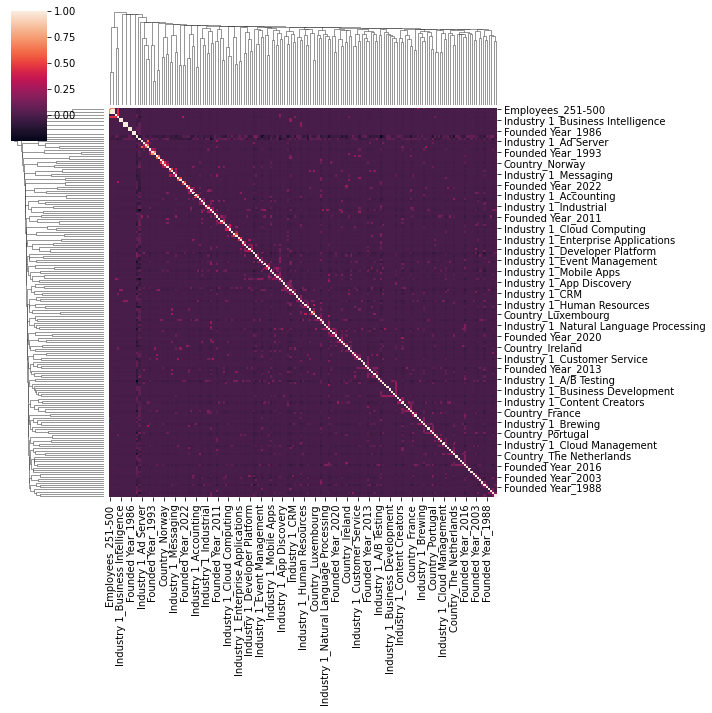

In [247]:
X = pd_stats.drop(GDPR_classes,axis=1) # independant features
X = pd.get_dummies(X, drop_first = True)
sns.clustermap(X.corr())

#### Split data

In [244]:
train, test = train_test_split(pd_stats, test_size=0.2, random_state=42)
X_train = train.drop(GDPR_classes,axis=1) # independant features

#### Encode non-numerical categorical data, and drop first to avoid collinearity

In [245]:
X_train = pd.get_dummies(X_train, drop_first = True)

# Parameter Optimization

#### First without PO

In [288]:
train, test = train_test_split(pd_stats, test_size=0.25, random_state=25)
sel_alpha_list = dict()
acc_last = 0

In [289]:
y_train = train[GDPR_classes[0]] # dependant variable
y_test = test[GDPR_classes[0]] # dependant variable

In [290]:
# independent features
X_train = train.drop(GDPR_classes, axis=1) 
# encode non-numerical categorical data, and drop first to avoid collinearity
X_train = pd.get_dummies(X_train, drop_first = True)

X_test = test.drop(GDPR_classes, axis=1) # independant features
X_test = pd.get_dummies(X_test, drop_first = True)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [294]:
X_train

,const,Employees_101-250,Employees_11-50,Employees_251-500,Employees_51-100,Industry 1_A/B Testing,Industry 1_Accounting,Industry 1_Ad Server,Industry 1_Advertising,Industry 1_Aerospace,Industry 1_Analytics,Industry 1_Android,Industry 1_Animation,Industry 1_App Discovery,Industry 1_Apps,Industry 1_Architecture,Industry 1_Artificial Intelligence,Industry 1_Asset Management,Industry 1_Association,Industry 1_Automotive,Industry 1_B2B,Industry 1_Big Data,Industry 1_Billing,Industry 1_Bitcoin,Industry 1_Blockchain,Industry 1_Brand Marketing,Industry 1_Brewing,Industry 1_Business Development,Industry 1_Business Information Systems,Industry 1_Business Intelligence,Industry 1_CMS,Industry 1_CRM,Industry 1_Charity,Industry 1_Cloud Computing,Industry 1_Cloud Data Services,Industry 1_Cloud Infrastructure,Industry 1_Cloud Management,Industry 1_Collaboration,Industry 1_Communications Infrastructure,Industry 1_Computer,Industry 1_Computer Vision,Industry 1_Consulting,Industry 1_Consumer Software,Industry 1_Content,Industry 1_Content Creators,Industry 1_Creative Agency,Industry 1_Crowdsourcing,Industry 1_Cryptocurrency,Industry 1_Customer Service,Industry 1_Cyber Security,Industry 1_Data Integration,Industry 1_Data Visualization,Industry 1_Database,Industry 1_Desktop Apps,Industry 1_Developer APIs,Industry 1_Developer Platform,Industry 1_Developer Tools,Industry 1_Digital Marketing,Industry 1_Digital Media,Industry 1_Digital Signage,Industry 1_Domain Registrar,Industry 1_E-Commerce,Industry 1_E-Commerce Platforms,Industry 1_E-Learning,Industry 1_EdTech,Industry 1_Education,Industry 1_Employment,Industry 1_Enterprise Applications,Industry 1_Enterprise Resource Planning (ERP),Industry 1_Enterprise Software,Industry 1_Event Management,Industry 1_FinTech,Industry 1_Finance,Industry 1_Financial Services,Industry 1_Food and Beverage,Industry 1_Gambling,Industry 1_Graphic Design,Industry 1_Hardware,Industry 1_Health Care,Industry 1_Human Resources,Industry 1_Industrial,Industry 1_Information Services,Industry 1_Information Technology,Industry 1_Infrastructure,Industry 1_Internet,Industry 1_Internet of Things,Industry 1_Lead Generation,Industry 1_Logistics,Industry 1_Marketing,Industry 1_Media and Entertainment,Industry 1_Messaging,Industry 1_Mobile Apps,Industry 1_Museums and Historical Sites,Industry 1_Natural Language Processing,Industry 1_Network Security,Industry 1_Online Portals,Industry 1_Outsourcing,Industry 1_PaaS,Industry 1_Photo Editing,Industry 1_Podcast,Industry 1_Productivity Tools,Industry 1_SEO,Industry 1_SaaS,Industry 1_Security,Industry 1_Social Media Marketing,Industry 1_Software,Industry 1_Training,Industry 1_UX Design,Industry 1_Web Apps,Founded Year_1986,Founded Year_1987,Founded Year_1988,Founded Year_1990,Founded Year_1993,Founded Year_1995,Founded Year_1996,Founded Year_1997,Founded Year_1998,Founded Year_1999,Founded Year_2000,Founded Year_2001,Founded Year_2002,Founded Year_2003,Founded Year_2004,Founded Year_2005,Founded Year_2006,Founded Year_2007,Founded Year_2008,Founded Year_2009,Founded Year_2010,Founded Year_2011,Founded Year_2012,Founded Year_2013,Founded Year_2014,Founded Year_2015,Founded Year_2016,Founded Year_2017,Founded Year_2018,Founded Year_2019,Founded Year_2020,Founded Year_2021,Founded Year_2022,Country_Austria,Country_Belarus,Country_Belgium,Country_Bosnia and Herzegovina,Country_Bulgaria,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Gibraltar,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Macedonia,Country_Malta,Country_Moldova,Country_Montenegro,Country_Norway,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Serbia,Country_Slovakia (Slovak Republic),Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_The Netherlands,Country_Turkey,Country_Ukraine,Country_United Kingdom
1390,1.0,0,0,0,0,0,0,0,0,0,

In [287]:
model = sm.Logit(y_train,X_train)
logit_model = model.fit()

C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
pred_train = logit_model.predict(X_train)>=.5
pred_test = logit_model.predict(X_test)>=.5

In [ ]:
acc_train = (y_train==pred_train).mean()
acc_test = (y_test==pred_test).mean()

print("Acc: ", acc_test)
print("Alpha: ", alpha_op)

In [279]:
alpha_list = list(np.arange(0.001, 10, 0.1))

##### Optimize parameters

In [282]:
opt_alpha = optimize_logit(pd_stats, True, alpha_list, True)

***************** NEW ROUND!
GDPR-category: Rights
349     1
1608    1
2308    1
2663    1
1778    1
       ..
2527    1
2164    0
1115    0
2166    0
1005    0
Name: Rights, Length: 340, dtype: category
Categories (2, int64): [0, 1]
flag 1
flag 2
Iteration limit reached    (Exit mode 9)
            Current function value: 0.3088550083961797
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000
flag 3
Acc:  0.611764705882353
Alpha:  0.001


C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 106 out of 181 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\aaberkan\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SystemExit: 0

C:\Users\aaberkan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [261]:
X_train

,Employees_101-250,Employees_11-50,Employees_251-500,Employees_51-100,Industry 1_A/B Testing,Industry 1_Accounting,Industry 1_Ad Server,Industry 1_Advertising,Industry 1_Aerospace,Industry 1_Analytics,Industry 1_Android,Industry 1_Animation,Industry 1_App Discovery,Industry 1_Apps,Industry 1_Architecture,Industry 1_Artificial Intelligence,Industry 1_Asset Management,Industry 1_Association,Industry 1_Automotive,Industry 1_B2B,Industry 1_Big Data,Industry 1_Billing,Industry 1_Bitcoin,Industry 1_Blockchain,Industry 1_Brand Marketing,Industry 1_Brewing,Industry 1_Business Development,Industry 1_Business Information Systems,Industry 1_Business Intelligence,Industry 1_CMS,Industry 1_CRM,Industry 1_Charity,Industry 1_Cloud Computing,Industry 1_Cloud Data Services,Industry 1_Cloud Infrastructure,Industry 1_Cloud Management,Industry 1_Collaboration,Industry 1_Communications Infrastructure,Industry 1_Computer,Industry 1_Computer Vision,Industry 1_Consulting,Industry 1_Consumer Software,Industry 1_Content,Industry 1_Content Creators,Industry 1_Creative Agency,Industry 1_Crowdsourcing,Industry 1_Cryptocurrency,Industry 1_Customer Service,Industry 1_Cyber Security,Industry 1_Data Integration,Industry 1_Data Visualization,Industry 1_Database,Industry 1_Desktop Apps,Industry 1_Developer APIs,Industry 1_Developer Platform,Industry 1_Developer Tools,Industry 1_Digital Marketing,Industry 1_Digital Media,Industry 1_Digital Signage,Industry 1_Domain Registrar,Industry 1_E-Commerce,Industry 1_E-Commerce Platforms,Industry 1_E-Learning,Industry 1_EdTech,Industry 1_Education,Industry 1_Employment,Industry 1_Enterprise Applications,Industry 1_Enterprise Resource Planning (ERP),Industry 1_Enterprise Software,Industry 1_Event Management,Industry 1_FinTech,Industry 1_Finance,Industry 1_Financial Services,Industry 1_Food and Beverage,Industry 1_Gambling,Industry 1_Graphic Design,Industry 1_Hardware,Industry 1_Health Care,Industry 1_Human Resources,Industry 1_Industrial,Industry 1_Information Services,Industry 1_Information Technology,Industry 1_Infrastructure,Industry 1_Internet,Industry 1_Internet of Things,Industry 1_Lead Generation,Industry 1_Logistics,Industry 1_Marketing,Industry 1_Media and Entertainment,Industry 1_Messaging,Industry 1_Mobile Apps,Industry 1_Museums and Historical Sites,Industry 1_Natural Language Processing,Industry 1_Network Security,Industry 1_Online Portals,Industry 1_Outsourcing,Industry 1_PaaS,Industry 1_Photo Editing,Industry 1_Podcast,Industry 1_Productivity Tools,Industry 1_SEO,Industry 1_SaaS,Industry 1_Security,Industry 1_Social Media Marketing,Industry 1_Software,Industry 1_Training,Industry 1_UX Design,Industry 1_Web Apps,Founded Year_1986,Founded Year_1987,Founded Year_1988,Founded Year_1990,Founded Year_1993,Founded Year_1995,Founded Year_1996,Founded Year_1997,Founded Year_1998,Founded Year_1999,Founded Year_2000,Founded Year_2001,Founded Year_2002,Founded Year_2003,Founded Year_2004,Founded Year_2005,Founded Year_2006,Founded Year_2007,Founded Year_2008,Founded Year_2009,Founded Year_2010,Founded Year_2011,Founded Year_2012,Founded Year_2013,Founded Year_2014,Founded Year_2015,Founded Year_2016,Founded Year_2017,Founded Year_2018,Founded Year_2019,Founded Year_2020,Founded Year_2021,Founded Year_2022,Country_Austria,Country_Belarus,Country_Belgium,Country_Bosnia and Herzegovina,Country_Bulgaria,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Gibraltar,Country_Greece,Country_Hungary,Country_Ireland,Country_Italy,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Macedonia,Country_Malta,Country_Moldova,Country_Montenegro,Country_Norway,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Serbia,Country_Slovakia (Slovak Republic),Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland,Country_The Netherlands,Country_Turkey,Country_Ukraine,Country_United Kingdom
141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [267]:
y_train

NameError: name 'y_train' is not defined

In [281]:
def optimize_logit(pd_stats, reg, alpha_range, intercept_set):
    train, test = train_test_split(pd_stats, test_size=0.2, random_state=25)
    sel_alpha_list = dict()
    acc_last = 0

    for GDPR_cat in GDPR_classes:
        alpha_sel = alpha_range[0]
        acc_last = 0

        print("***************** NEW ROUND!")
        for alpha_op in alpha_range:
            print("GDPR-category: " + GDPR_class)

            y_train = train[GDPR_class] # dependant variable
            y_test = test[GDPR_class] # dependant variable
            
#             sys.exit(0)

            # independent features
            X_train = train.drop(GDPR_classes, axis=1) 
            # encode non-numerical categorical data, and drop first to avoid collinearity
            X_train = pd.get_dummies(X_train, drop_first = True)

            X_test = test.drop(GDPR_classes, axis=1) # independant features
            X_test = pd.get_dummies(X_test, drop_first = True)

            if(intercept_set):
                X_train = sm.add_constant(X_train)
                X_test = sm.add_constant(X_test)
                
            print(y_train)

            print("flag 1")
            model = sm.Logit(y_train,X_train)
            print("flag 2")

            if(reg):
                logit_model = model.fit_regularized(method = 'l1', trim_mode = 'size', alpha = alpha_op)
            else:
                logit_model = model.fit()

            print("flag 3")

            pred_train = logit_model.predict(X_train)>=.5

            pred_test = logit_model.predict(X_test)>=.5

            acc_train = (y_train==pred_train).mean()

            acc_test = (y_test==pred_test).mean()
            
            print("Acc: ", acc_test)
            print("Alpha: ", alpha_op)

            sys.exit(0)
            if(acc_test >= acc_last):
                print("Alpha selected!")
                alpha_sel = alpha_op 
                acc_last = acc_test

            # last alpha in range? Place optimized alpha and accuracy in dict
            if(alpha_op == alpha_list[-1]):
                sel_alpha_list[GDPR_class] = [alpha_sel, acc_last]
            
            print()
            print()

    return sel_alpha_list